# Bioinformatic - Pipeline Comparison for BLG 604E

## OUTLINE

#### PART A) RESULTS FROM THE PIPELINES
1- Reading SNP vcf filenames generated as a result of the pipeline.
<br> 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

#### PART B) RESULTS OF THE LL VALIDATED VCFS
1- Reading ll validated vcfs.
<br> 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

#### PART C) SET OPERATIONS
1- Creating a set operations funtions. 
<br>2- Creating a intersection array from each sets. 
<br>3- Show Intersection Results in heatmap

#### PART D) COMPARISON WITH UNION VALIDATED VCF'S
1- Create an union of all ll validated vfc sets for each data.
<br>2- Show results in heatmap.

#### PART E) OPENCRAVAT DATA
1- 

## ABOUT DATA
50-51 : LL DATA
<br>44-45 : NC DATA
<br>79-80 : FD1 DATA
<br>74-83 : Il_1 DATA
<br>18-19 : EA DATA
<br> 47-52: NV DATA

## IMPORT SECTION

In [1]:
import os
import allel
import numpy as np # pip3 install matplotlib
import matplotlib.pyplot as plt # pip3 install matplotlib

import random
import community # can be installed with: "pip install python-louvain"
from numpy import linalg as LA
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import math
import scipy.io as sio
from skimage import data, segmentation, color
from skimage.future import graph
from sklearn.preprocessing import MinMaxScaler

In [151]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### Common Funtions

In [2]:
#Deleting indels from VCF
def remove_indels(t):
    t = t[t["REF"].apply(len) == 1 ]
    t = t[t["ALT_1"].apply(len) == 1]
    return t 

#Normalization
def normalization(df):
    return MinMaxScaler().fit_transform(np.array(df['Results']).reshape(-1,1))

#Apply Filters
def filtersControl(key,df):
    df = df.copy()
    
    #Getting variantCaller Name
    VCName = key.split('/')
    
    #Apply Filter Pass if not somaticSniper
    df = df if VCName[len(VCName)-1] == 'somaticSniper' else df[df["FILTER_PASS"]]
    
    #SOMATIC filter on strelka
    df = df[df['SOMATIC'].astype("bool")] if VCName[len(VCName)-1] == 'strelka' else df
        
    return df

## PART A) RESULTS FROM THE PIPELINES

### 1- Reading SNP vcf filenames generated as a result of the pipeline.

In [3]:
snp_filenames = {}
for root, directories, filenames in os.walk('vcf/snp'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            snp_filenames[root[8:]] = os.path.join(root,fn)

In [4]:
len(snp_filenames)

36

### 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

In [5]:
sets_dict = {}

filtering_df = pd.DataFrame(columns=["Key", "Total Length", "After FilterPass", "After RemoveIndels"])

for key in tqdm(snp_filenames):
    
    #Creating a dataframe for each vcf.
    temp = allel.vcf_to_dataframe(snp_filenames[key],fields='variants/*')
    #print(key)
    #display(temp.head())
    #Filtering - STARTS
    total_len = len(temp)
    temp = filtersControl(key,temp) #FilterPass control for somaticSniper
    after_Filterpass_len = len(temp)
    temp = remove_indels(temp) 
    without_indels_len = len(temp)
    #temp = temp[temp["CHROM"].apply(lambda x: "_" in x)]
    #Filtering - ENDS
    
    #For printing changes in the vcf lengths
    filtering_df.loc[len(filtering_df.index)] = [key , total_len, after_Filterpass_len,without_indels_len]
    
    #Creating a dictionary for each set
    if len(temp) != 0:
        sets_dict[key]= set(temp[["CHROM","POS","REF","ALT_1"]].apply(lambda row: "_".join(map(str, row)), axis=1))

100%|███████████████████████████████████████████| 36/36 [00:19<00:00,  1.81it/s]


In [285]:
snp_filenames

{'FD1/bowtie/somaticSniper': 'vcf/snp/FD1/bowtie/somaticSniper/snp_SRR7890880_bowtie-SRR7890879_bowtie_somaticsniper.vcf.SNPfilter',
 'FD1/bowtie/strelka': 'vcf/snp/FD1/bowtie/strelka/snp_SRR7890880_bowtie-SRR7890879_bowtie_strelka.vcf',
 'FD1/bowtie/mutect': 'vcf/snp/FD1/bowtie/mutect/snp_SRR7890880_bowtie-SRR7890879_bowtie_mutect.vcf',
 'FD1/bwa2/somaticSniper': 'vcf/snp/FD1/bwa2/somaticSniper/snp_SRR7890880_bwa2-SRR7890879_bwa2_somaticsniper.vcf.SNPfilter',
 'FD1/bwa2/strelka': 'vcf/snp/FD1/bwa2/strelka/snp_SRR7890880_bwa2-SRR7890879_bwa2_strelka.vcf',
 'FD1/bwa2/mutect': 'vcf/snp/FD1/bwa2/mutect/snp_SRR7890880_bwa2-SRR7890879_bwa2_mutect.vcf',
 'IL1/bowtie/somaticSniper': 'vcf/snp/IL1/bowtie/somaticSniper/snp_SRR7890874_bowtie-SRR7890883_bowtie_somaticsniper.vcf.SNPfilter',
 'IL1/bowtie/strelka': 'vcf/snp/IL1/bowtie/strelka/snp_SRR7890874_bowtie-SRR7890883_bowtie_strelka.vcf',
 'IL1/bowtie/mutect': 'vcf/snp/IL1/bowtie/mutect/snp_SRR7890874_bowtie-SRR7890883_bowtie_mutect.vcf',
 'IL

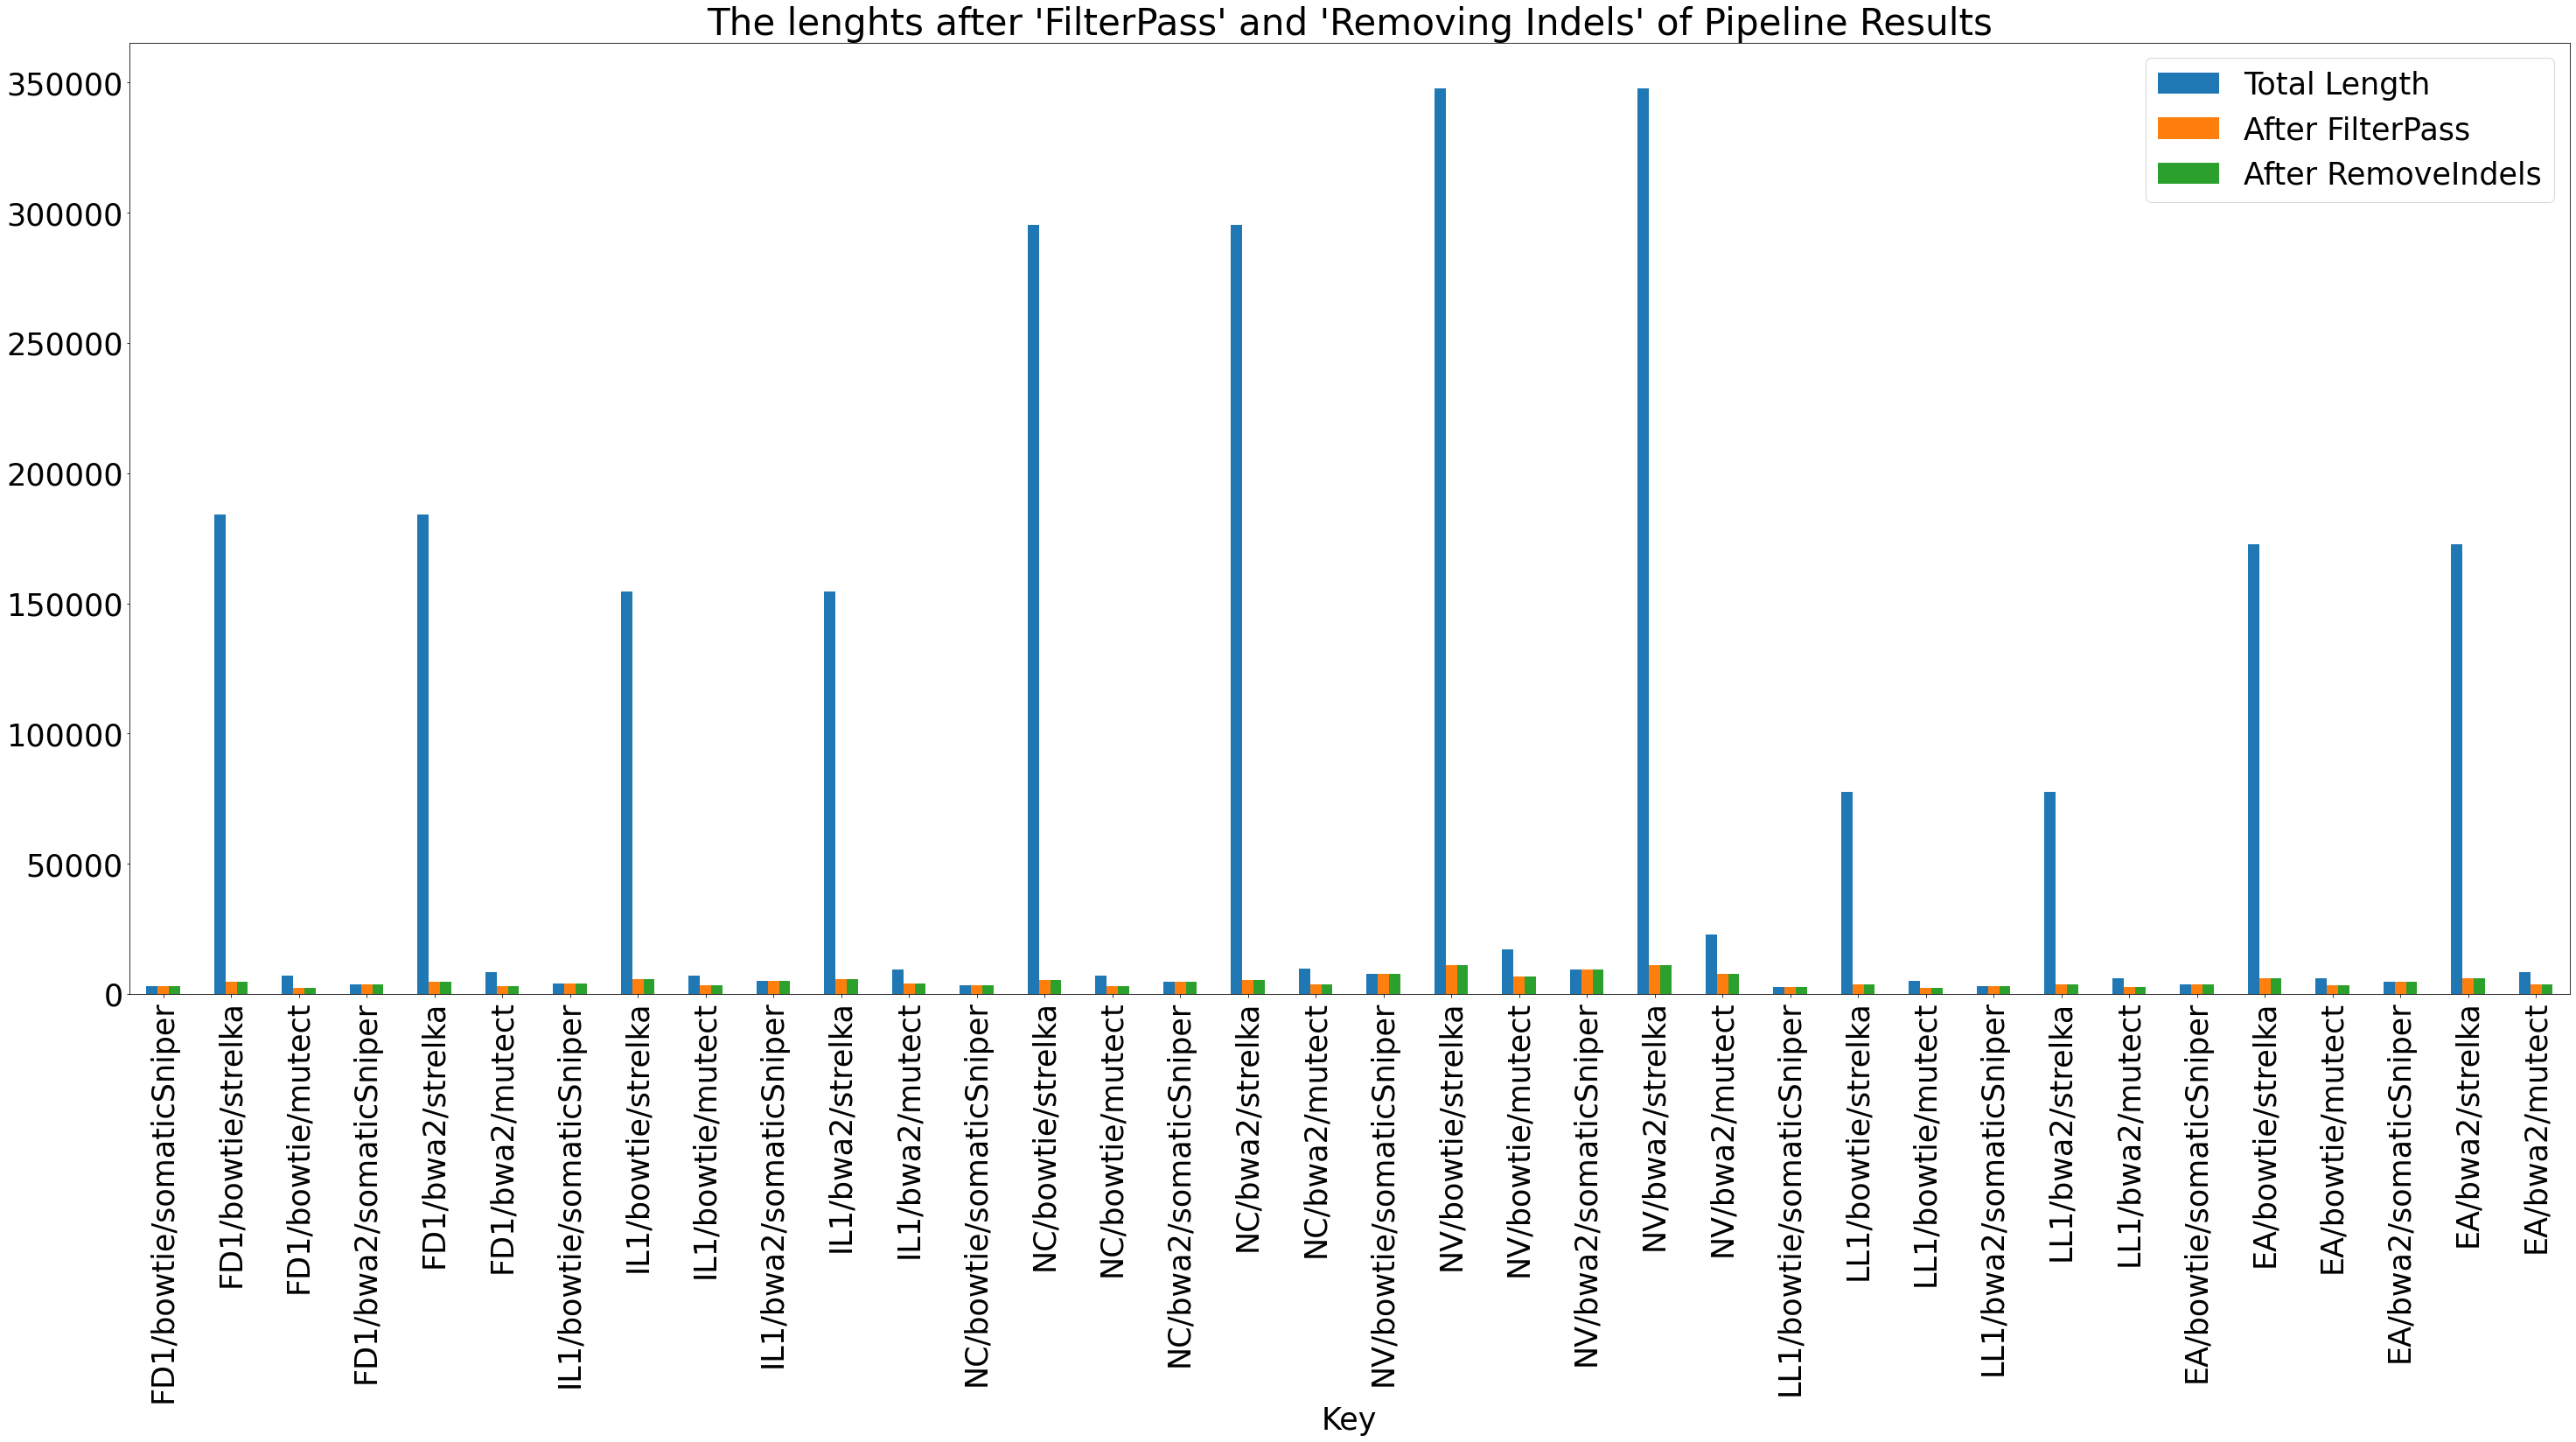

In [156]:
#Example
#len(sets_dict)
#len(sets_dict['50_51/bowtie/octopus'])
plt.rcParams.update({'font.size': 35}) # must set in top
ax = filtering_df.plot('Key',kind='bar',title="The lenghts after 'FilterPass' and 'Removing Indels' of Pipeline Results",figsize=(50,20))
for p in ax.patches:
    if p.get_height() == 0:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## PART B) RESULTS OF THE LL VALIDATED VCFS

### 1- Reading ll validated vcfs.

In [7]:
ll_filenames = {}
for root, directories, filenames in os.walk('vcf/validated_vcfs'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            ll_filenames[root[19:]] = os.path.join(root,fn)

In [8]:
len(ll_filenames)

54

### 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

In [265]:
ll_sets_dict = {}

ll_filtering_df = pd.DataFrame(columns=["Key", "Total Length", "After FilterPass", "After RemoveIndels"])

for key in tqdm(ll_filenames):
    #Creating a dataframe for each vcf.
    temp = allel.vcf_to_dataframe(ll_filenames[key],fields='variants/*')
    
    #Filtering - STARTS
    total_length = len(temp)
    temp = filtersControl(key,temp) #FilterPass control for somaticSniper
    after_filterpass = len(temp)
    temp = remove_indels(temp)
    after_remove_indels = len(temp)
    #Filtering - ENDS
    
    #For printing changes in the vcf lengths
    ll_filtering_df.loc[len(ll_filtering_df.index)] = [key , total_length, after_filterpass,after_remove_indels]

    #Creating a set for each dataframe
    if len(temp) != 0 :
        ll_sets_dict[key]= set(temp[["CHROM","POS","REF","ALT_1"]].apply(lambda row: "_".join(map(str, row)), axis=1))

100%|███████████████████████████████████████████| 54/54 [00:16<00:00,  3.31it/s]


In [271]:
key

'EA/bowtie/mutect'

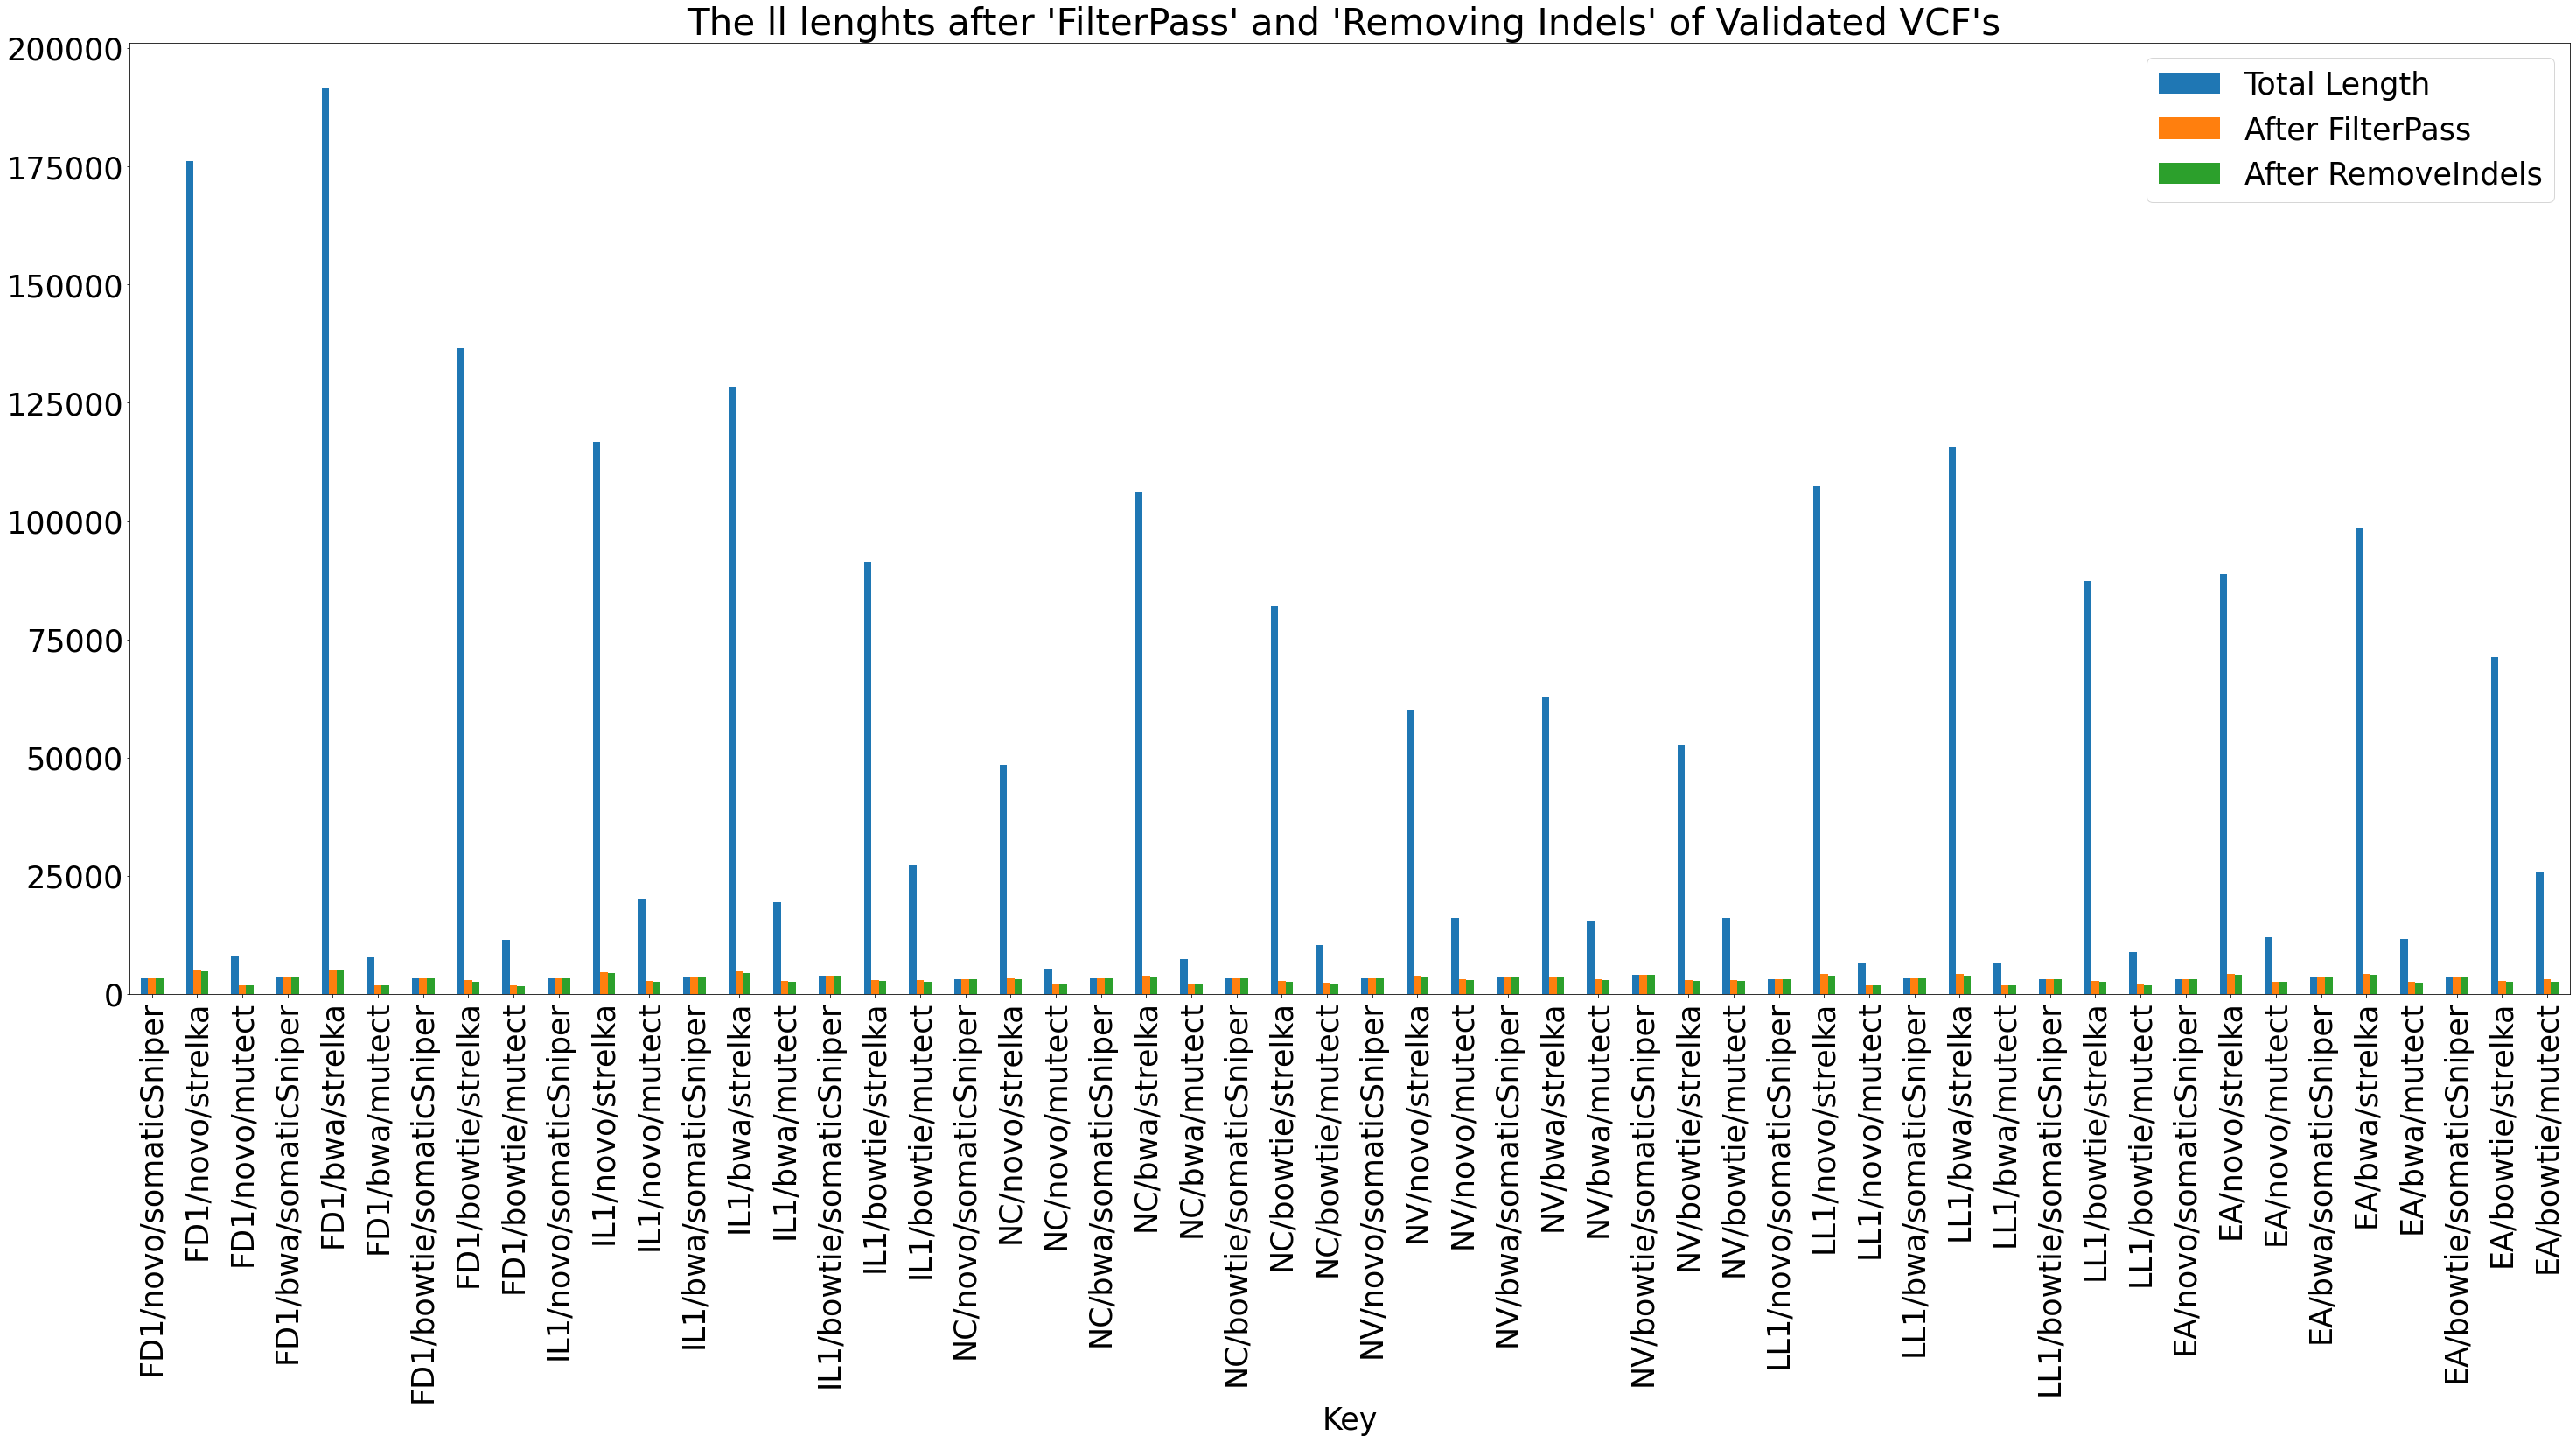

In [267]:
plt.rcParams.update({'font.size': 35}) # must set in top
ax = ll_filtering_df.plot('Key',kind='bar',title="The ll lenghts after 'FilterPass' and 'Removing Indels' of Validated VCF's ",figsize=(50,20))
for p in ax.patches:
    if p.get_height() == 0:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## PART C) SET OPERATIONS


### 1- Creating a set operations funtions.

In [11]:
#The intersection of two sets is the set of all the common elements of both the sets. 
def intersec(s1,s2):
    return len(s1.intersection(s2))

#The union of two sets is the set of all the elements of both the sets without duplicates.
def uni(s1,s2):
    return len(s1.union(s2))

#The difference between two sets is the set of all the elements in first set that are not present in the second set. 
def dif(s1,s2):
    return len(s1.difference(s2))

#Jaccard Similarity function for two sets ( int / )
def js_set(s1, s2):
    intersection = len(list(set(s1).intersection(s2)))
    union = uni(s1,s2)
    return np.float64(round((float(intersection) / union) * 100) / 100);

### 2- Creating a intersection array from each sets. 

In [12]:
#Initializing a dataframe
df_js = pd.DataFrame(columns=["LL_VCF", "Result_VCF", "Results"])

#Initializing a count for the rows
count = 0

#Computing each intersection of ll and the pipeline vcfs by looking at their key values. 
for key1 in tqdm(ll_sets_dict): 
    for key2 in sets_dict:
        d_temp = pd.DataFrame([[key1, key2, js_set(ll_sets_dict[key1],sets_dict[key2])]],
                   columns=['LL_VCF', 'Result_VCF',"Results"])
        df_js = pd.concat((df_js,d_temp), ignore_index = True)
    
#Normalizing the results values with MinMaxScaler [0,1]
#df_t['Results'] = MinMaxScaler().fit_transform(np.array(df_t['Results']).reshape(-1,1))

#df_t
df_js

100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.28it/s]


LL_VCF                Result_VCF  Results
0     FD1/novo/somaticSniper  FD1/bowtie/somaticSniper     0.43
1     FD1/novo/somaticSniper        FD1/bowtie/strelka     0.36
2     FD1/novo/somaticSniper         FD1/bowtie/mutect     0.44
3     FD1/novo/somaticSniper    FD1/bwa2/somaticSniper     0.39
4     FD1/novo/somaticSniper          FD1/bwa2/strelka     0.36
...                      ...                       ...      ...
1939        EA/bowtie/mutect         EA/bowtie/strelka     0.27
1940        EA/bowtie/mutect          EA/bowtie/mutect     0.45
1941        EA/bowtie/mutect     EA/bwa2/somaticSniper     0.28
1942        EA/bowtie/mutect           EA/bwa2/strelka     0.27
1943        EA/bowtie/mutect            EA/bwa2/mutect     0.41

[1944 rows x 3 columns]

### 3- Show Intersection Results in heatmap

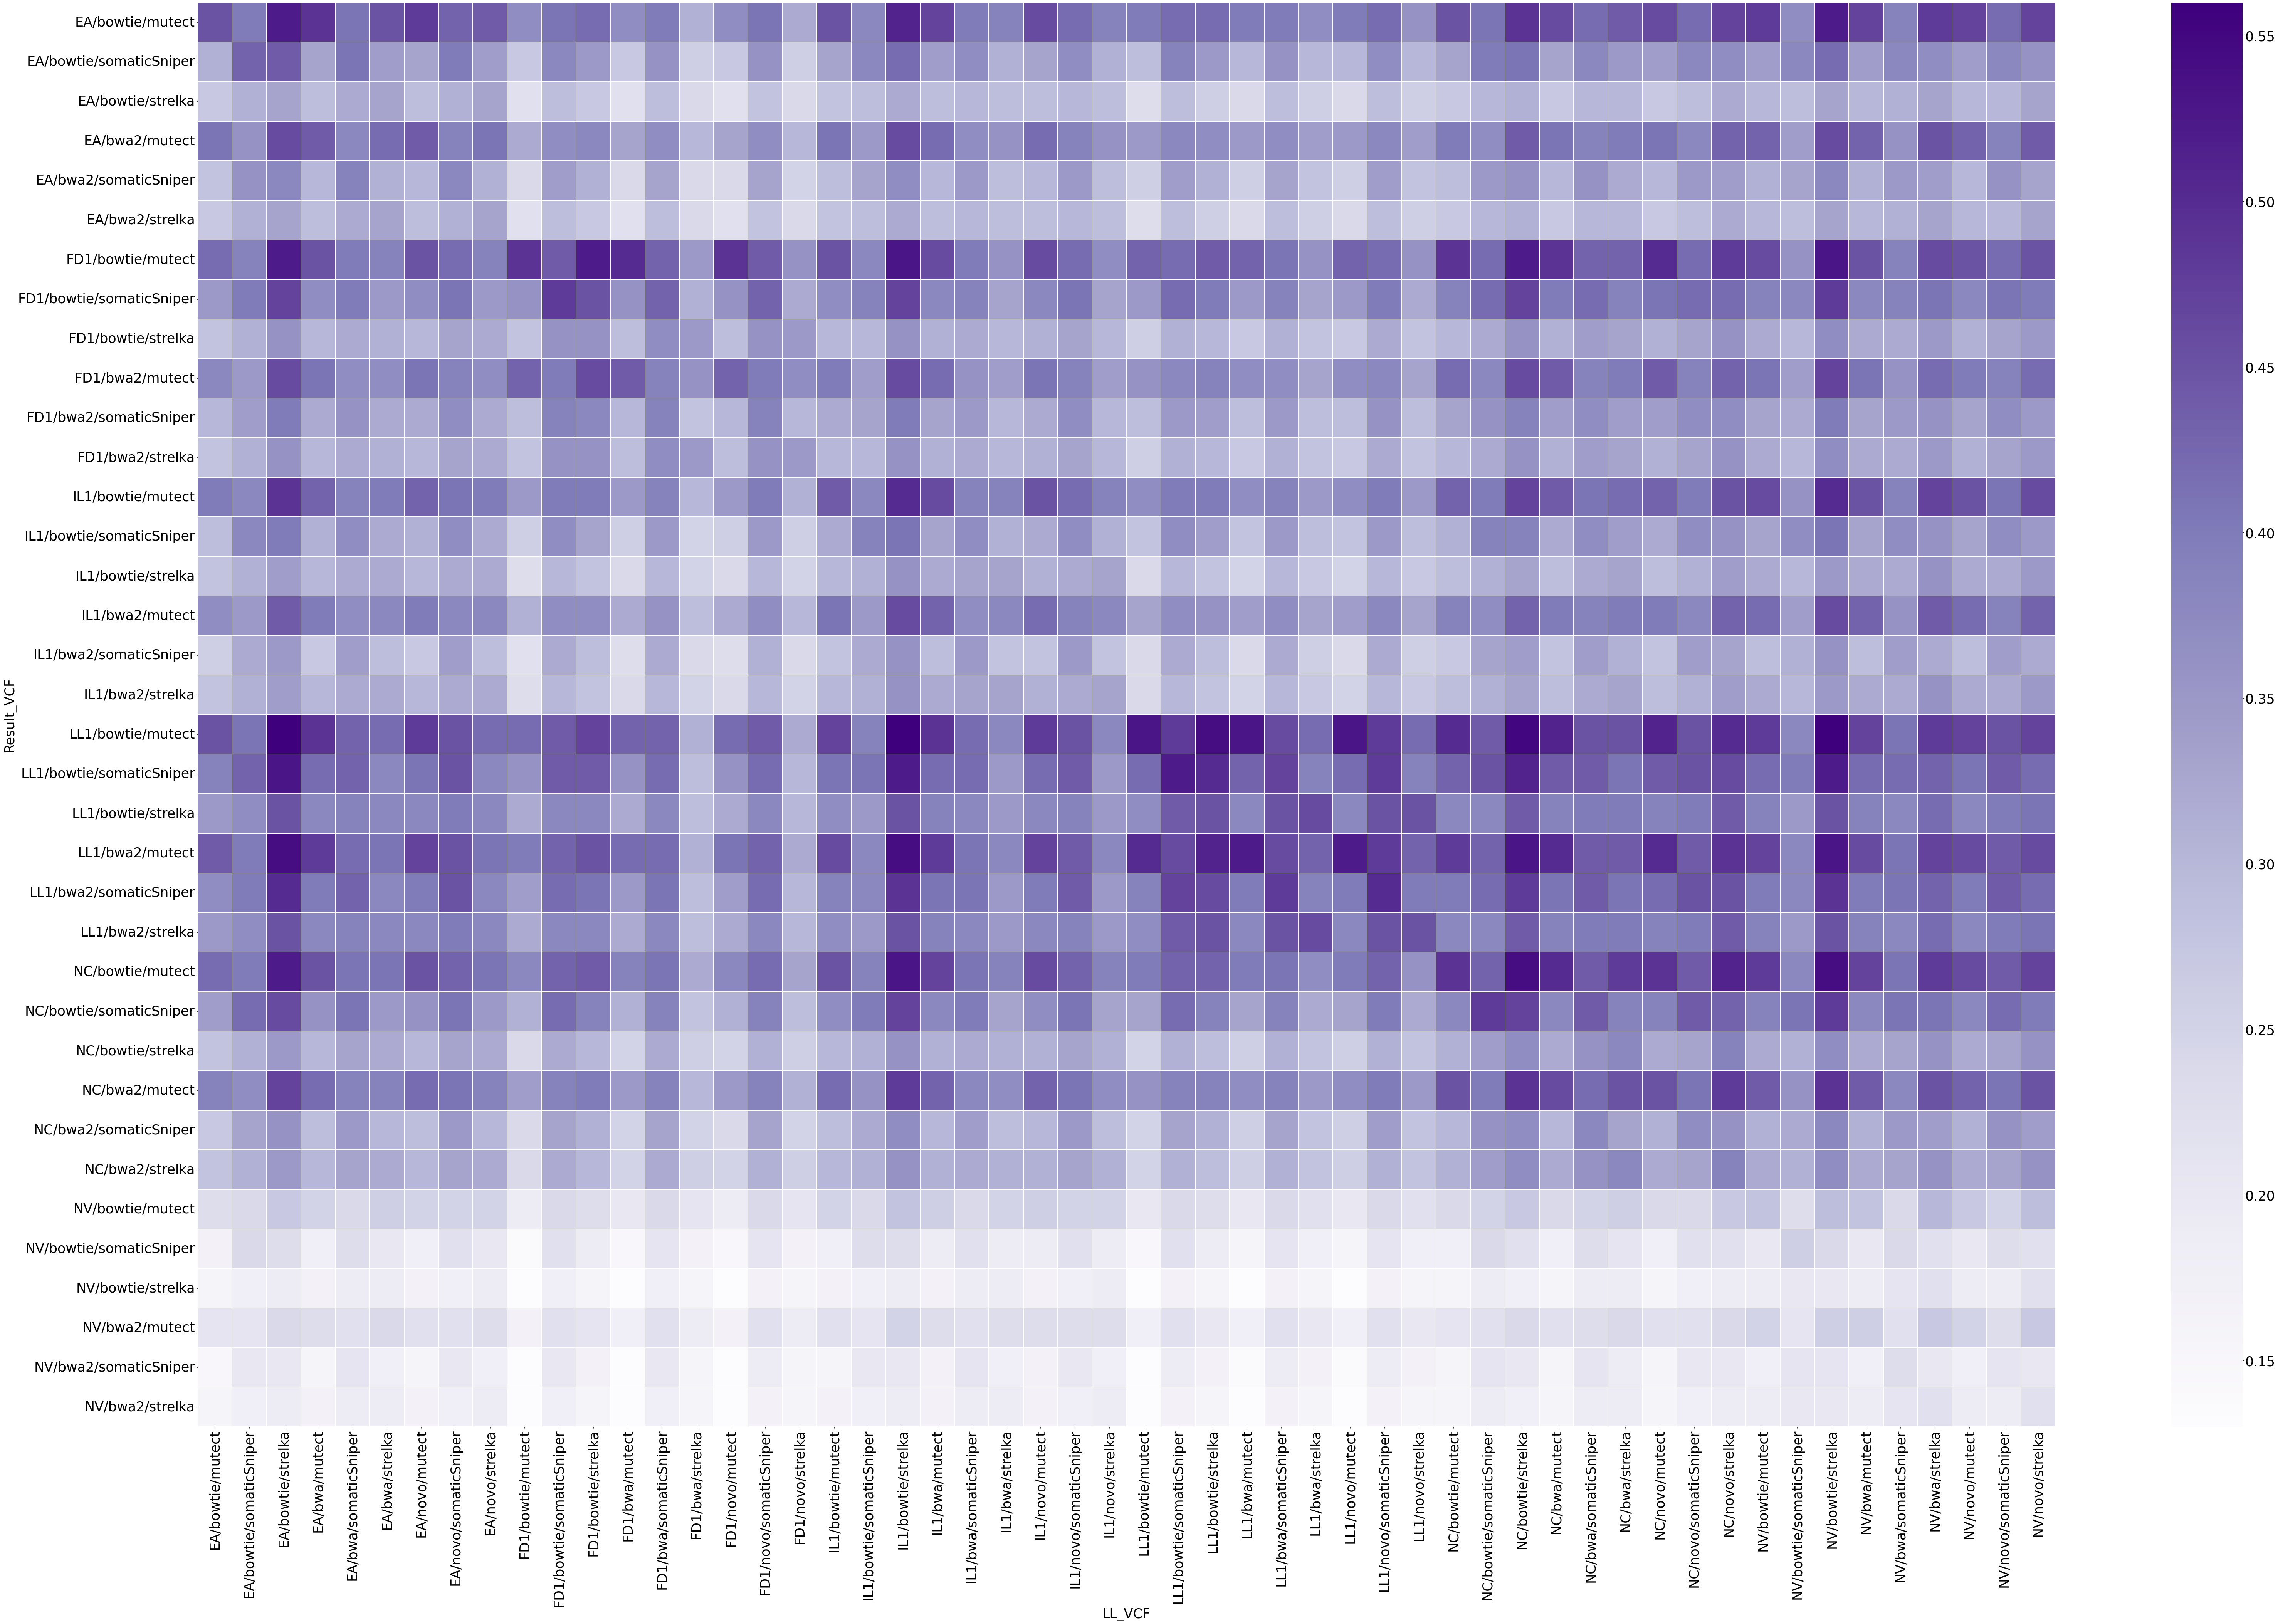

In [258]:
plt.figure(figsize = (108,68))
df_h = df_js.pivot("Result_VCF", "LL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_h, annot=False, cmap="Purples", linewidths=.1)

In [220]:
t_novo = []
t_bwa = []
t_bowtie = []

for index,row in df_js.iterrows():
    if row['LL_VCF'].split('/')[1] == 'novo' and row['Result_VCF'].split('/')[1] == 'novo':
        t_novo.append(row)
    elif row['LL_VCF'].split('/')[1] == 'bwa'and row['Result_VCF'].split('/')[1] == 'bwa2':
        t_bwa.append(row)
    elif row['LL_VCF'].split('/')[1] == 'bowtie' and row['Result_VCF'].split('/')[1] == 'bowtie' :
        t_bowtie.append(row)

In [201]:
df_novo = pd.DataFrame(t_novo , columns=["LL_VCF", "Result_VCF", "Results"])
df_bwa = pd.DataFrame(t_bwa, columns=["LL_VCF", "Result_VCF", "Results"])
df_bowtie = pd.DataFrame(t_bowtie,columns=["LL_VCF", "Result_VCF", "Results"])
df_bowtie

LL_VCF                Result_VCF  Results
216   FD1/bowtie/somaticSniper  FD1/bowtie/somaticSniper     0.48
217   FD1/bowtie/somaticSniper        FD1/bowtie/strelka     0.36
218   FD1/bowtie/somaticSniper         FD1/bowtie/mutect     0.44
222   FD1/bowtie/somaticSniper  IL1/bowtie/somaticSniper     0.37
223   FD1/bowtie/somaticSniper        IL1/bowtie/strelka     0.30
224   FD1/bowtie/somaticSniper         IL1/bowtie/mutect     0.40
228   FD1/bowtie/somaticSniper   NC/bowtie/somaticSniper     0.42
229   FD1/bowtie/somaticSniper         NC/bowtie/strelka     0.32
230   FD1/bowtie/somaticSniper          NC/bowtie/mutect     0.43
234   FD1/bowtie/somaticSniper   NV/bowtie/somaticSniper     0.22
235   FD1/bowtie/somaticSniper         NV/bowtie/strelka     0.18
236   FD1/bowtie/somaticSniper          NV/bowtie/mutect     0.24
240   FD1/bowtie/somaticSniper  LL1/bowtie/somaticSniper     0.44
241   FD1/bowtie/somaticSniper        LL1/bowtie/strelka     0.38
242   FD1/bowtie/somaticSniper         LL1/bowtie/mutect     0.44
246   FD1/bowtie/somaticSniper   EA/bowtie/somaticSniper     0.38
247   FD1/bowtie/somaticSniper         EA/bowtie/strelka     0.29
248   FD1/bowtie/somaticSniper          EA/bowtie/mutect     0.41
252         FD1/bowtie/strelka  FD1/bowtie/somaticSniper     0.45
253         FD1/bowtie/strelka        FD1/bowtie/strelka     0.36
254         FD1/bowtie/strelka         FD1/bowtie/mutect     0.52
258         FD1/bowtie/strelka  IL1/bowtie/somaticSniper     0.33
259         FD1/bowtie/strelka        IL1/bowtie/strelka     0.28
260         FD1/bowtie/strelka         IL1/bowtie/mutect     0.40
264         FD1/bowtie/strelka   NC/bowtie/somaticSniper     0.39
265         FD1/bowtie/strelka         NC/bowtie/strelka     0.30
266         FD1/bowtie/strelka          NC/bowtie/mutect     0.44
270         FD1/bowtie/strelka   NV/bowtie/somaticSniper     0.19
271         FD1/bowtie/strelka         NV/bowtie/strelka     0.16
272         FD1/bowtie/strelka          NV/bowtie/mutect     0.23
276         FD1/bowtie/strelka  LL1/bowtie/somaticSniper     0.44
277         FD1/bowtie/strelka        LL1/bowtie/strelka     0.38
278         FD1/bowtie/strelka         LL1/bowtie/mutect     0.47
282         FD1/bowtie/strelka   EA/bowtie/somaticSniper     0.35
283         FD1/bowtie/strelka         EA/bowtie/strelka     0.27
284         FD1/bowtie/strelka          EA/bowtie/mutect     0.42
288          FD1/bowtie/mutect  FD1/bowtie/somaticSniper     0.36
289          FD1/bowtie/mutect        FD1/bowtie/strelka     0.28
290          FD1/bowtie/mutect         FD1/bowtie/mutect     0.49
294          FD1/bowtie/mutect  IL1/bowtie/somaticSniper     0.26
295          FD1/bowtie/mutect        IL1/bowtie/strelka     0.23
296          FD1/bowtie/mutect         IL1/bowtie/mutect     0.35
300          FD1/bowtie/mutect   NC/bowtie/somaticSniper     0.31
301          FD1/bowtie/mutect         NC/bowtie/strelka     0.24
302          FD1/bowtie/mutect          NC/bowtie/mutect     0.38
306          FD1/bowtie/mutect   NV/bowtie/somaticSniper     0.14
307          FD1/bowtie/mutect         NV/bowtie/strelka     0.13
308          FD1/bowtie/mutect          NV/bowtie/mutect     0.19
312          FD1/bowtie/mutect  LL1/bowtie/somaticSniper     0.36
313          FD1/bowtie/mutect        LL1/bowtie/strelka     0.32
314          FD1/bowtie/mutect         LL1/bowtie/mutect     0.42
318          FD1/bowtie/mutect   EA/bowtie/somaticSniper     0.27
319          FD1/bowtie/mutect         EA/bowtie/strelka     0.22
320          FD1/bowtie/mutect          EA/bowtie/mutect     0.37
540   IL1/bowtie/somaticSniper  FD1/bowtie/somaticSniper     0.39
541   IL1/bowtie/somaticSniper        FD1/bowtie/strelka     0.30
542   IL1/bowtie/somaticSniper         FD1/bowtie/mutect     0.38
546   IL1/bowtie/somaticSniper  IL1/bowtie/somaticSniper     0.39
547   IL1/bowtie/somaticSniper        IL1/bowtie/strelka     0.31
548   IL1/bowtie/somaticSniper         IL1/bowtie/mutect     0.3

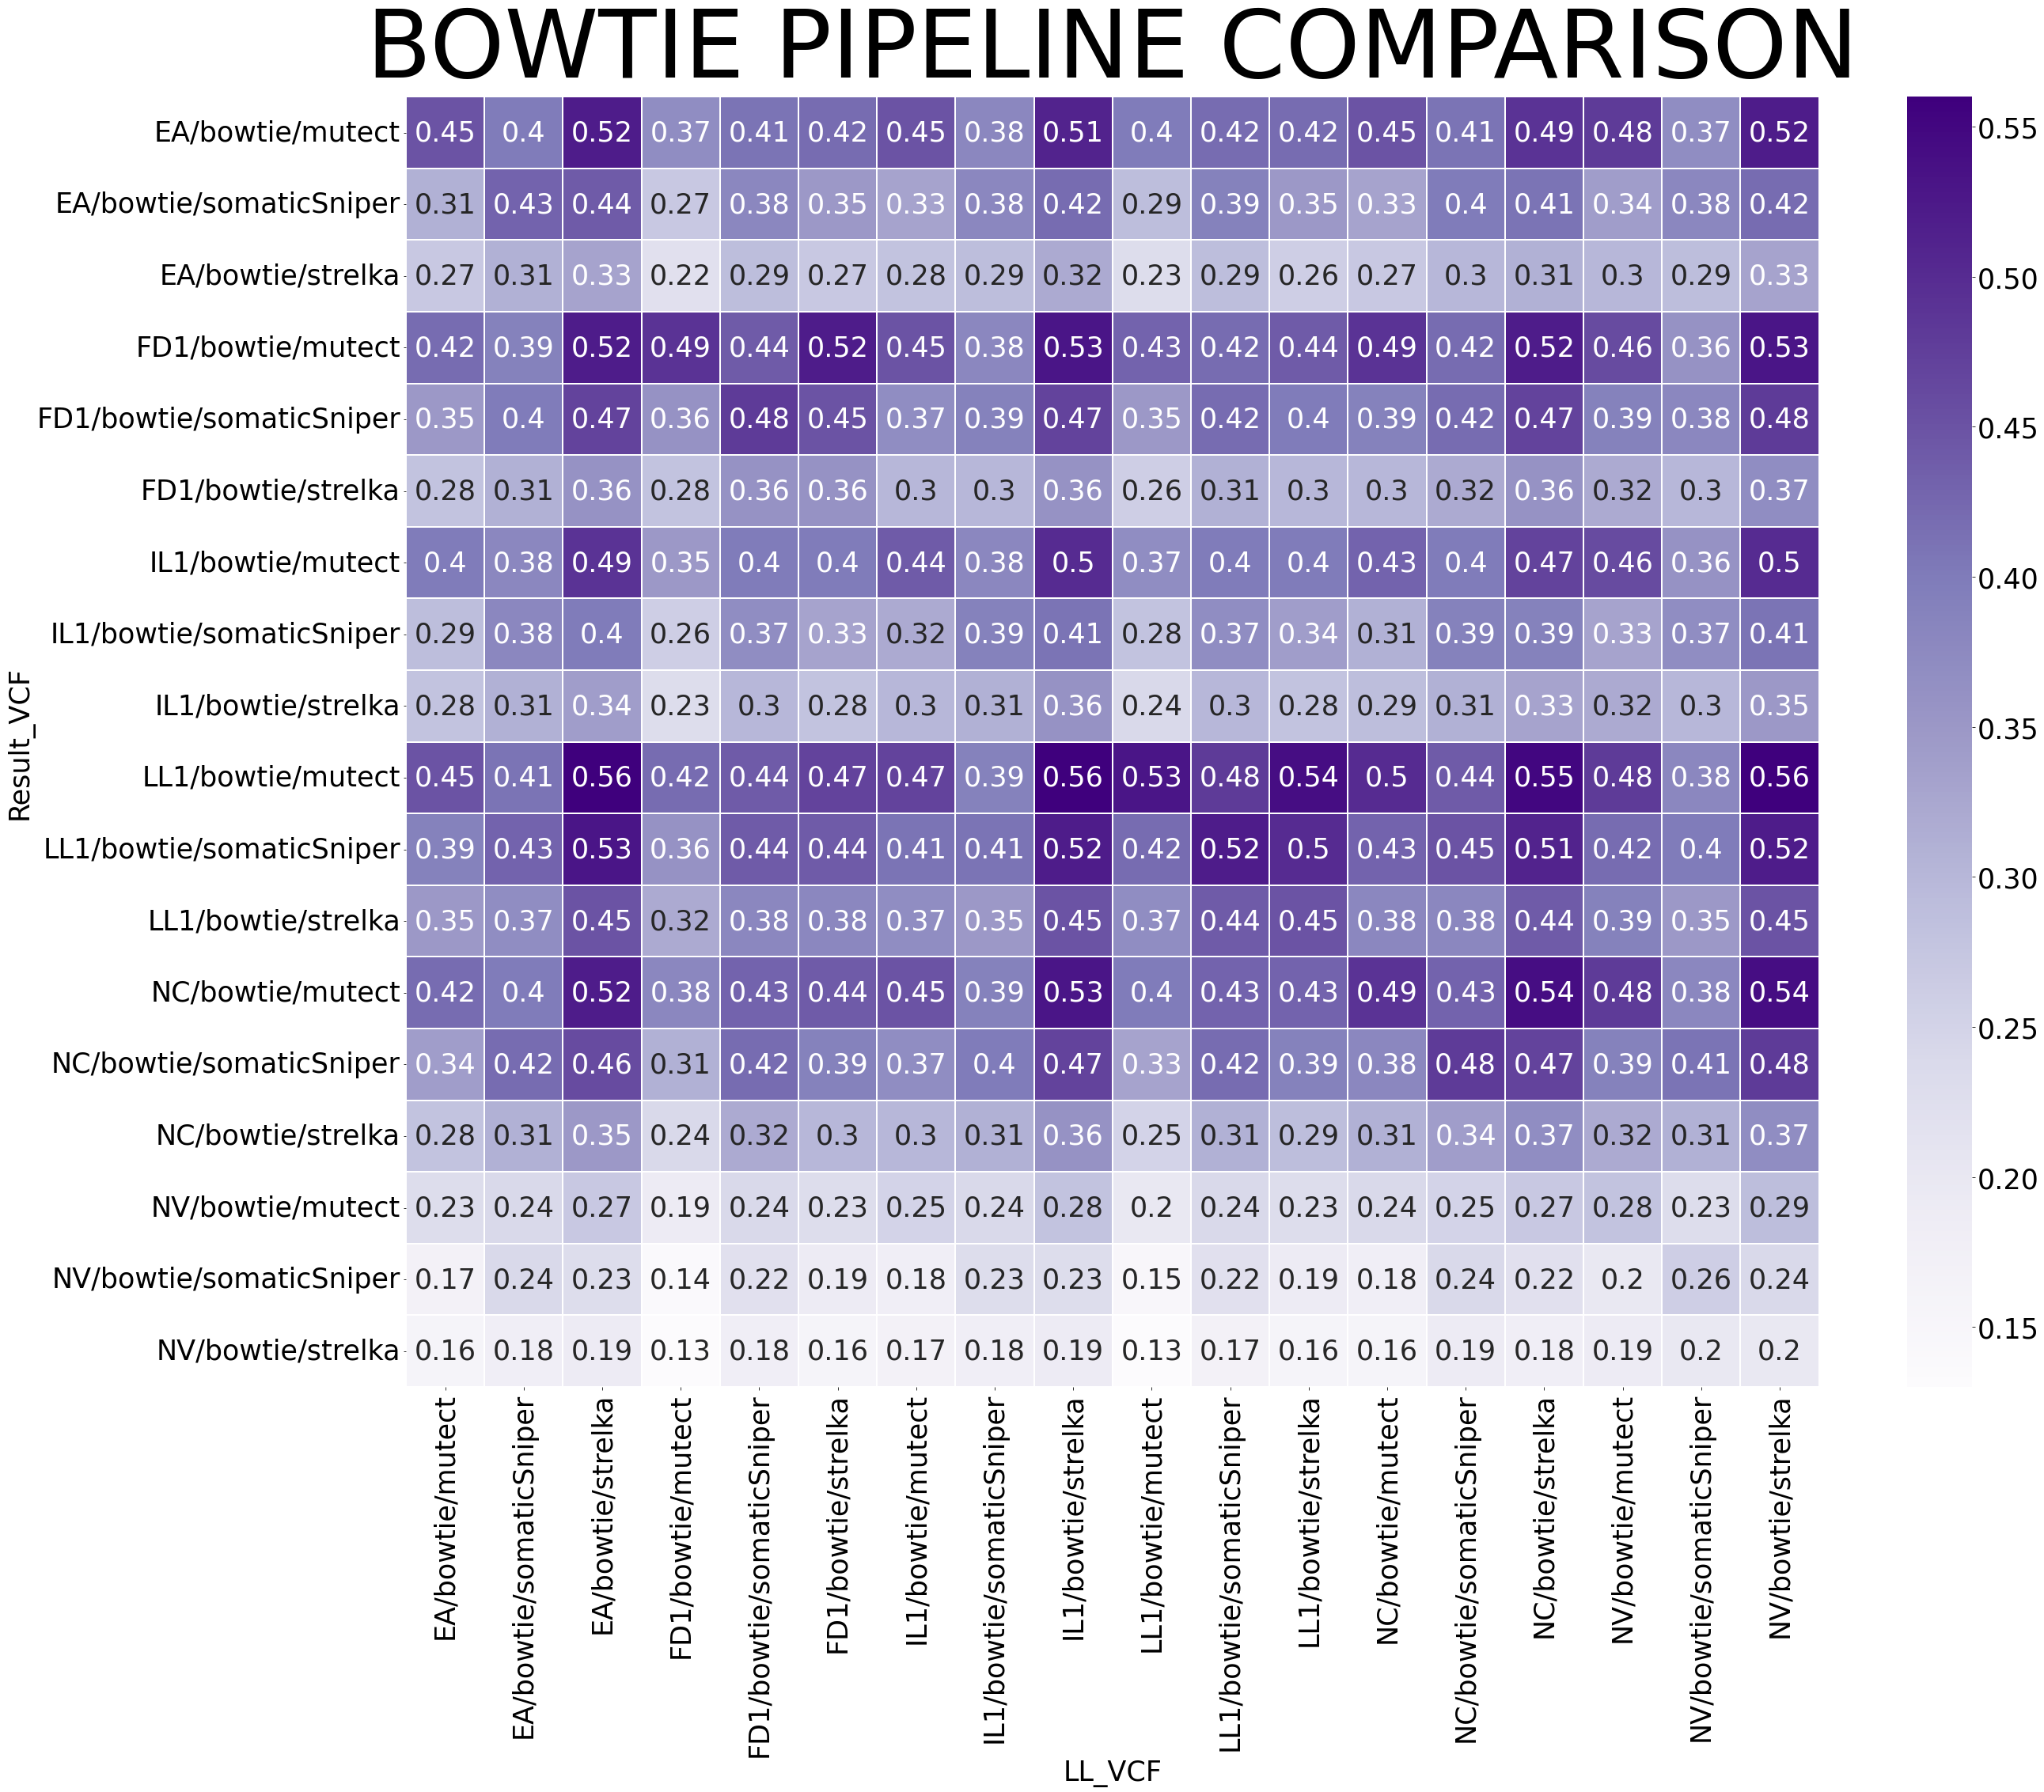

In [259]:
###BOWTIE
plt.figure(figsize = (40,30))
plt.title('BOWTIE PIPELINE COMPARISON', size = 120)
df_bowtie_h = df_bowtie.pivot("Result_VCF", "LL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_bowtie_h, annot=True, cmap="Purples", linewidths=.2)


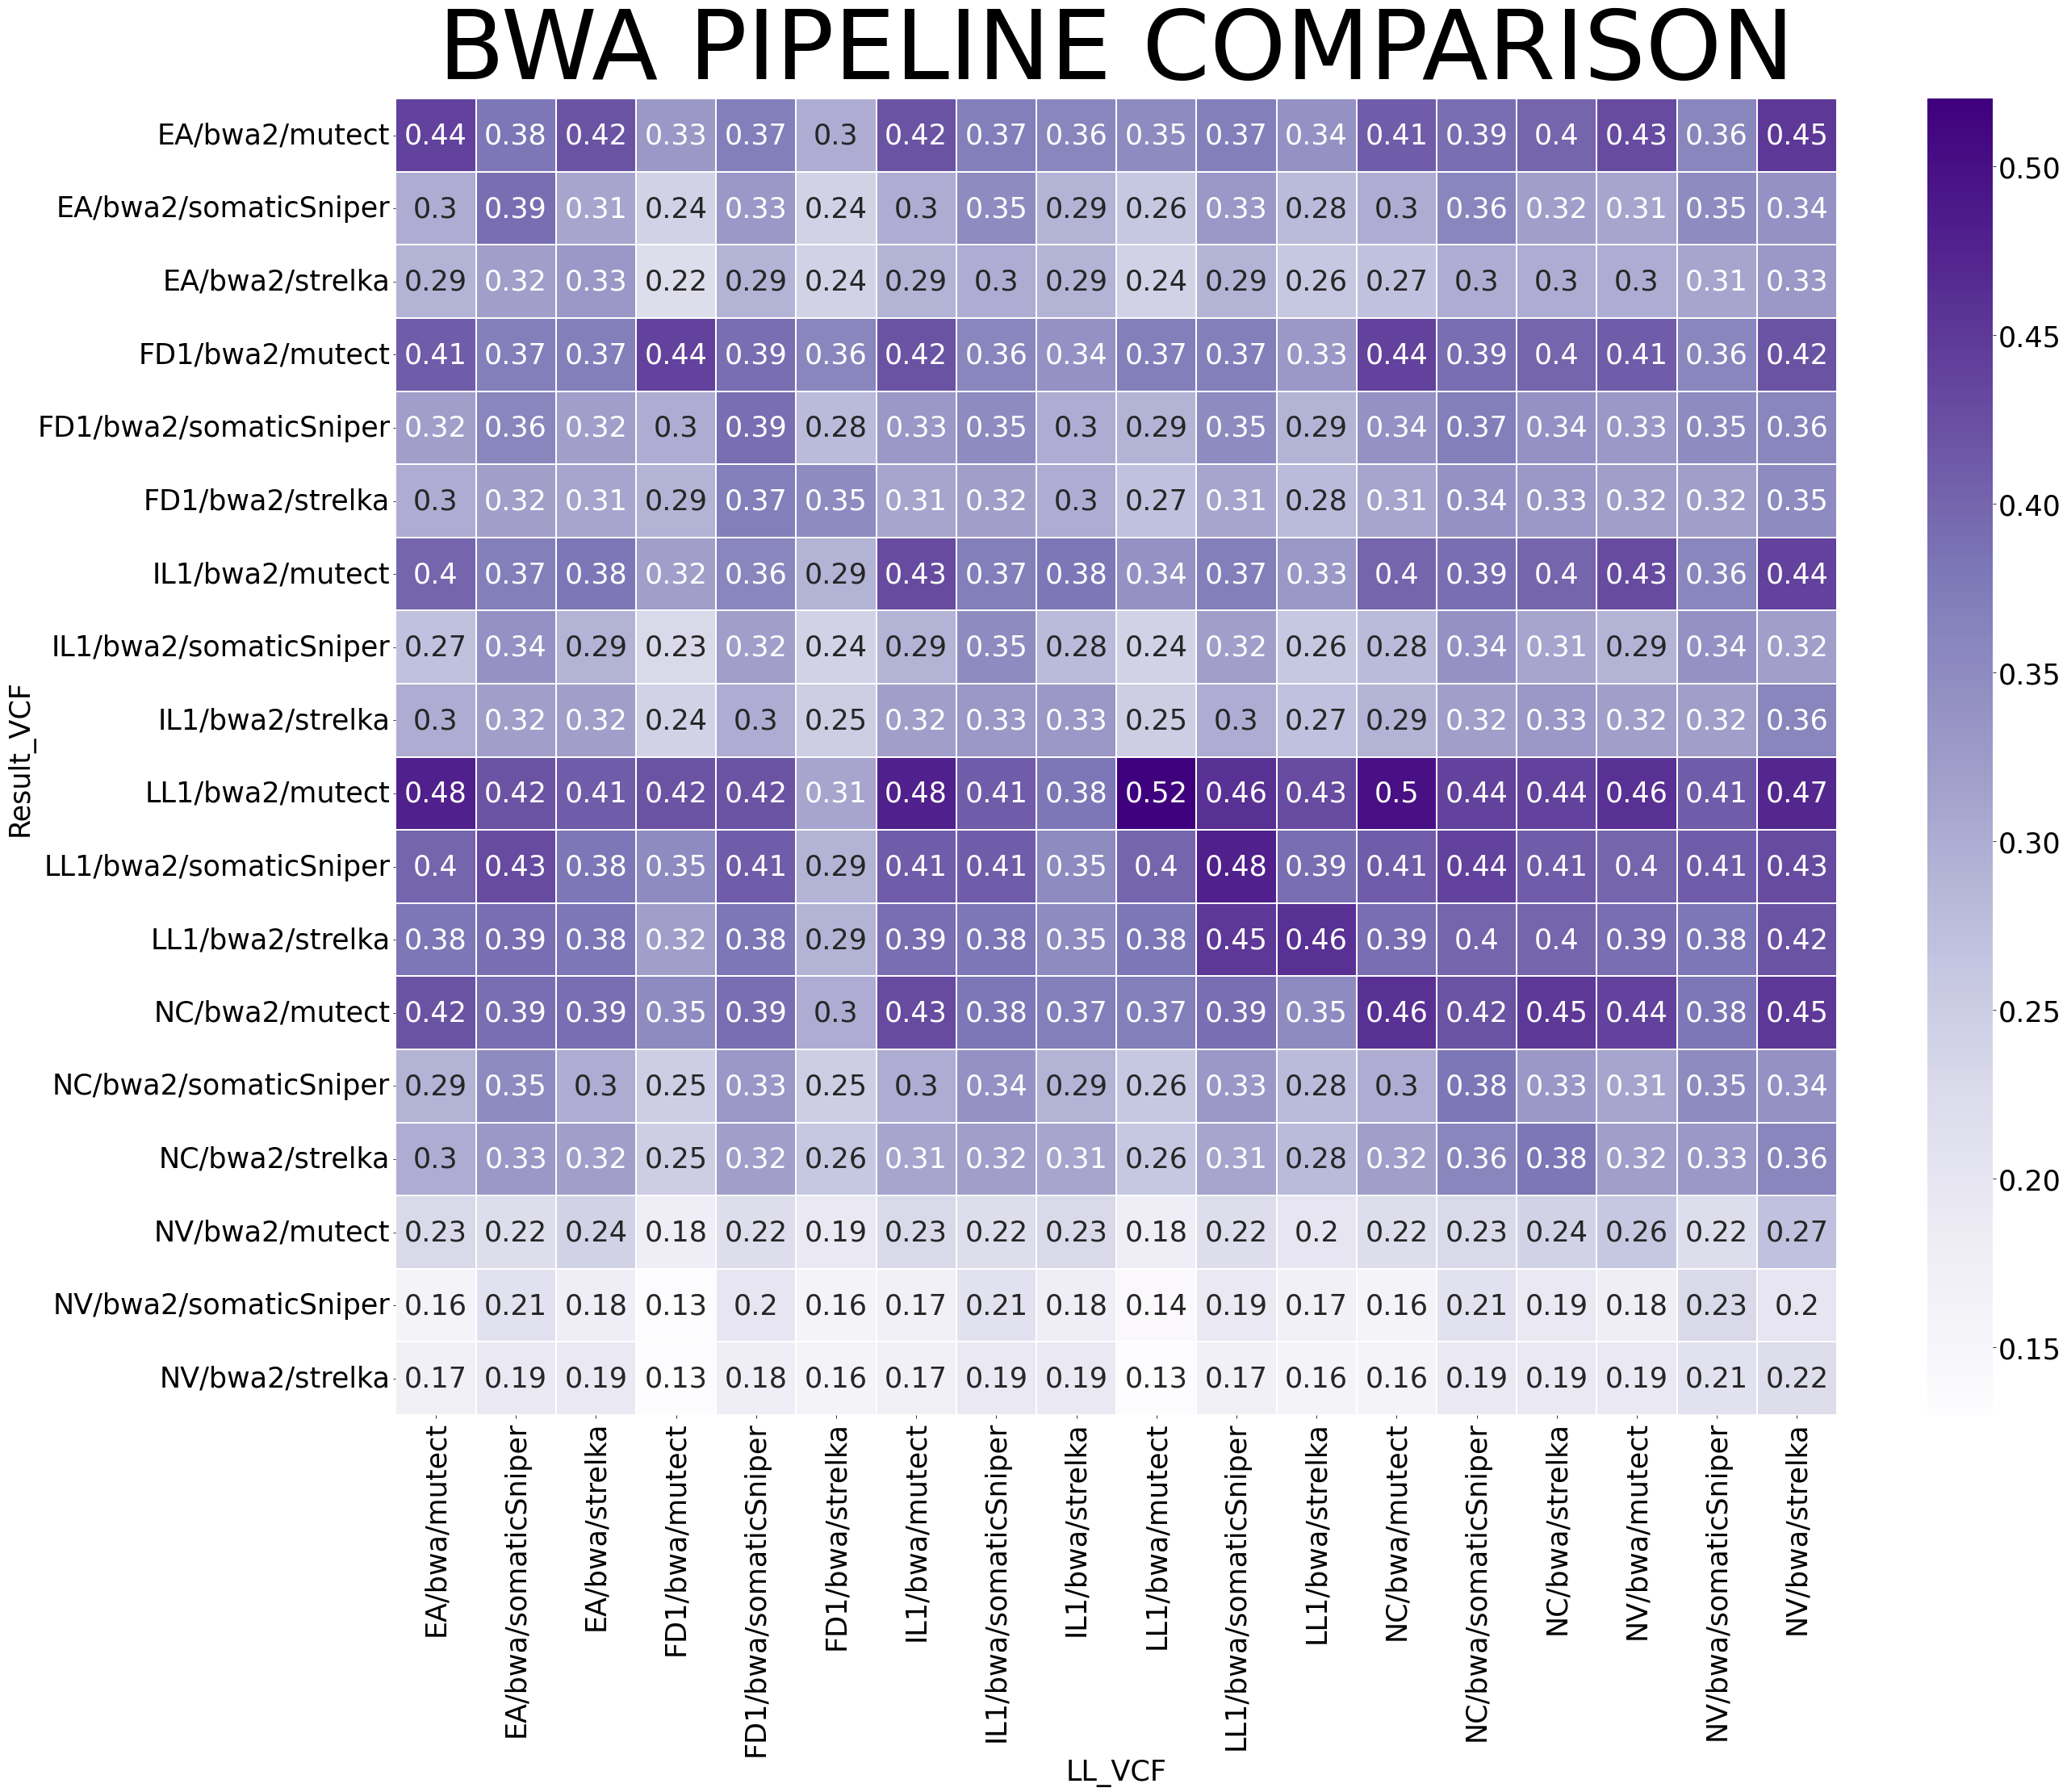

In [260]:
###BWA
plt.figure(figsize = (40,30))
plt.title('BWA PIPELINE COMPARISON', size = 120)
df_bwa_h = df_bwa.pivot("Result_VCF", "LL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_bwa_h, annot=True, cmap="Purples", linewidths=.2)

### VARIANT CALLER

In [235]:
t_mutect = []
t_ss = []
t_strelka = []

for index,row in df_js.iterrows():
    if row['LL_VCF'].split('/')[2] == 'mutect' and row['Result_VCF'].split('/')[2] == 'mutect':
        t_mutect.append(row)
    elif row['LL_VCF'].split('/')[2] == 'somaticSniper'and row['Result_VCF'].split('/')[2] == 'somaticSniper':
        t_ss.append(row)
    elif row['LL_VCF'].split('/')[2] == 'strelka' and row['Result_VCF'].split('/')[2] == 'strelka' :
        t_strelka.append(row)
        

In [236]:
df_mutect = pd.DataFrame(t_mutect , columns=["LL_VCF", "Result_VCF", "Results"])
df_ss = pd.DataFrame(t_ss, columns=["LL_VCF", "Result_VCF", "Results"])
df_strelka = pd.DataFrame(t_strelka,columns=["LL_VCF", "Result_VCF", "Results"])
df_ss

LL_VCF                Result_VCF  Results
0       FD1/novo/somaticSniper  FD1/bowtie/somaticSniper     0.43
3       FD1/novo/somaticSniper    FD1/bwa2/somaticSniper     0.39
6       FD1/novo/somaticSniper  IL1/bowtie/somaticSniper     0.35
9       FD1/novo/somaticSniper    IL1/bwa2/somaticSniper     0.31
12      FD1/novo/somaticSniper   NC/bowtie/somaticSniper     0.39
15      FD1/novo/somaticSniper     NC/bwa2/somaticSniper     0.33
18      FD1/novo/somaticSniper   NV/bowtie/somaticSniper     0.21
21      FD1/novo/somaticSniper     NV/bwa2/somaticSniper     0.19
24      FD1/novo/somaticSniper  LL1/bowtie/somaticSniper     0.42
27      FD1/novo/somaticSniper    LL1/bwa2/somaticSniper     0.42
30      FD1/novo/somaticSniper   EA/bowtie/somaticSniper     0.36
33      FD1/novo/somaticSniper     EA/bwa2/somaticSniper     0.33
108      FD1/bwa/somaticSniper  FD1/bowtie/somaticSniper     0.43
111      FD1/bwa/somaticSniper    FD1/bwa2/somaticSniper     0.39
114      FD1/bwa/somaticSniper  IL1/bowtie/somaticSniper     0.35
117      FD1/bwa/somaticSniper    IL1/bwa2/somaticSniper     0.32
120      FD1/bwa/somaticSniper   NC/bowtie/somaticSniper     0.39
123      FD1/bwa/somaticSniper     NC/bwa2/somaticSniper     0.33
126      FD1/bwa/somaticSniper   NV/bowtie/somaticSniper     0.21
129      FD1/bwa/somaticSniper     NV/bwa2/somaticSniper     0.20
132      FD1/bwa/somaticSniper  LL1/bowtie/somaticSniper     0.42
135      FD1/bwa/somaticSniper    LL1/bwa2/somaticSniper     0.41
138      FD1/bwa/somaticSniper   EA/bowtie/somaticSniper     0.36
141      FD1/bwa/somaticSniper     EA/bwa2/somaticSniper     0.33
216   FD1/bowtie/somaticSniper  FD1/bowtie/somaticSniper     0.48
219   FD1/bowtie/somaticSniper    FD1/bwa2/somaticSniper     0.39
222   FD1/bowtie/somaticSniper  IL1/bowtie/somaticSniper     0.37
225   FD1/bowtie/somaticSniper    IL1/bwa2/somaticSniper     0.32
228   FD1/bowtie/somaticSniper   NC/bowtie/somaticSniper     0.42
231   FD1/bowtie/somaticSniper     NC/bwa2/somaticSniper     0.33
234   FD1/bowtie/somaticSniper   NV/bowtie/somaticSniper     0.22
237   FD1/bowtie/somaticSniper     NV/bwa2/somaticSniper     0.20
240   FD1/bowtie/somaticSniper  LL1/bowtie/somaticSniper     0.44
243   FD1/bowtie/somaticSniper    LL1/bwa2/somaticSniper     0.42
246   FD1/bowtie/somaticSniper   EA/bowtie/somaticSniper     0.38
249   FD1/bowtie/somaticSniper     EA/bwa2/somaticSniper     0.34
324     IL1/novo/somaticSniper  FD1/bowtie/somaticSniper     0.41
327     IL1/novo/somaticSniper    FD1/bwa2/somaticSniper     0.37
330     IL1/novo/somaticSniper  IL1/bowtie/somaticSniper     0.37
333     IL1/novo/somaticSniper    IL1/bwa2/somaticSniper     0.35
336     IL1/novo/somaticSniper   NC/bowtie/somaticSniper     0.41
339     IL1/novo/somaticSniper     NC/bwa2/somaticSniper     0.35
342     IL1/novo/somaticSniper   NV/bowtie/somaticSniper     0.22
345     IL1/novo/somaticSniper     NV/bwa2/somaticSniper     0.20
348     IL1/novo/somaticSniper  LL1/bowtie/somaticSniper     0.44
351     IL1/novo/somaticSniper    LL1/bwa2/somaticSniper     0.44
354     IL1/novo/somaticSniper   EA/bowtie/somaticSniper     0.37
357     IL1/novo/somaticSniper     EA/bwa2/somaticSniper     0.35
432      IL1/bwa/somaticSniper  FD1/bowtie/somaticSniper     0.39
435      IL1/bwa/somaticSniper    FD1/bwa2/somaticSniper     0.35
438      IL1/bwa/somaticSniper  IL1/bowtie/somaticSniper     0.37
441      IL1/bwa/somaticSniper    IL1/bwa2/somaticSniper     0.35
444      IL1/bwa/somaticSniper   NC/bowtie/somaticSniper     0.40
447      IL1/bwa/somaticSniper     NC/bwa2/somaticSniper     0.34
450      IL1/bwa/somaticSniper   NV/bowtie/somaticSniper     0.22
453      IL1/bwa/somaticSniper     NV/bwa2/somaticSniper     0.21
456      IL1/bwa/somaticSniper  LL1/bowtie/somaticSniper     0.42
459      IL1/bwa/somaticSniper    LL1/bwa2/somaticSniper     0.41
462      IL1/bwa/somaticSniper   EA/bowtie/somaticSniper     0.37
465      IL1/bwa/somaticSniper     EA/bwa2/somaticSniper     0.3

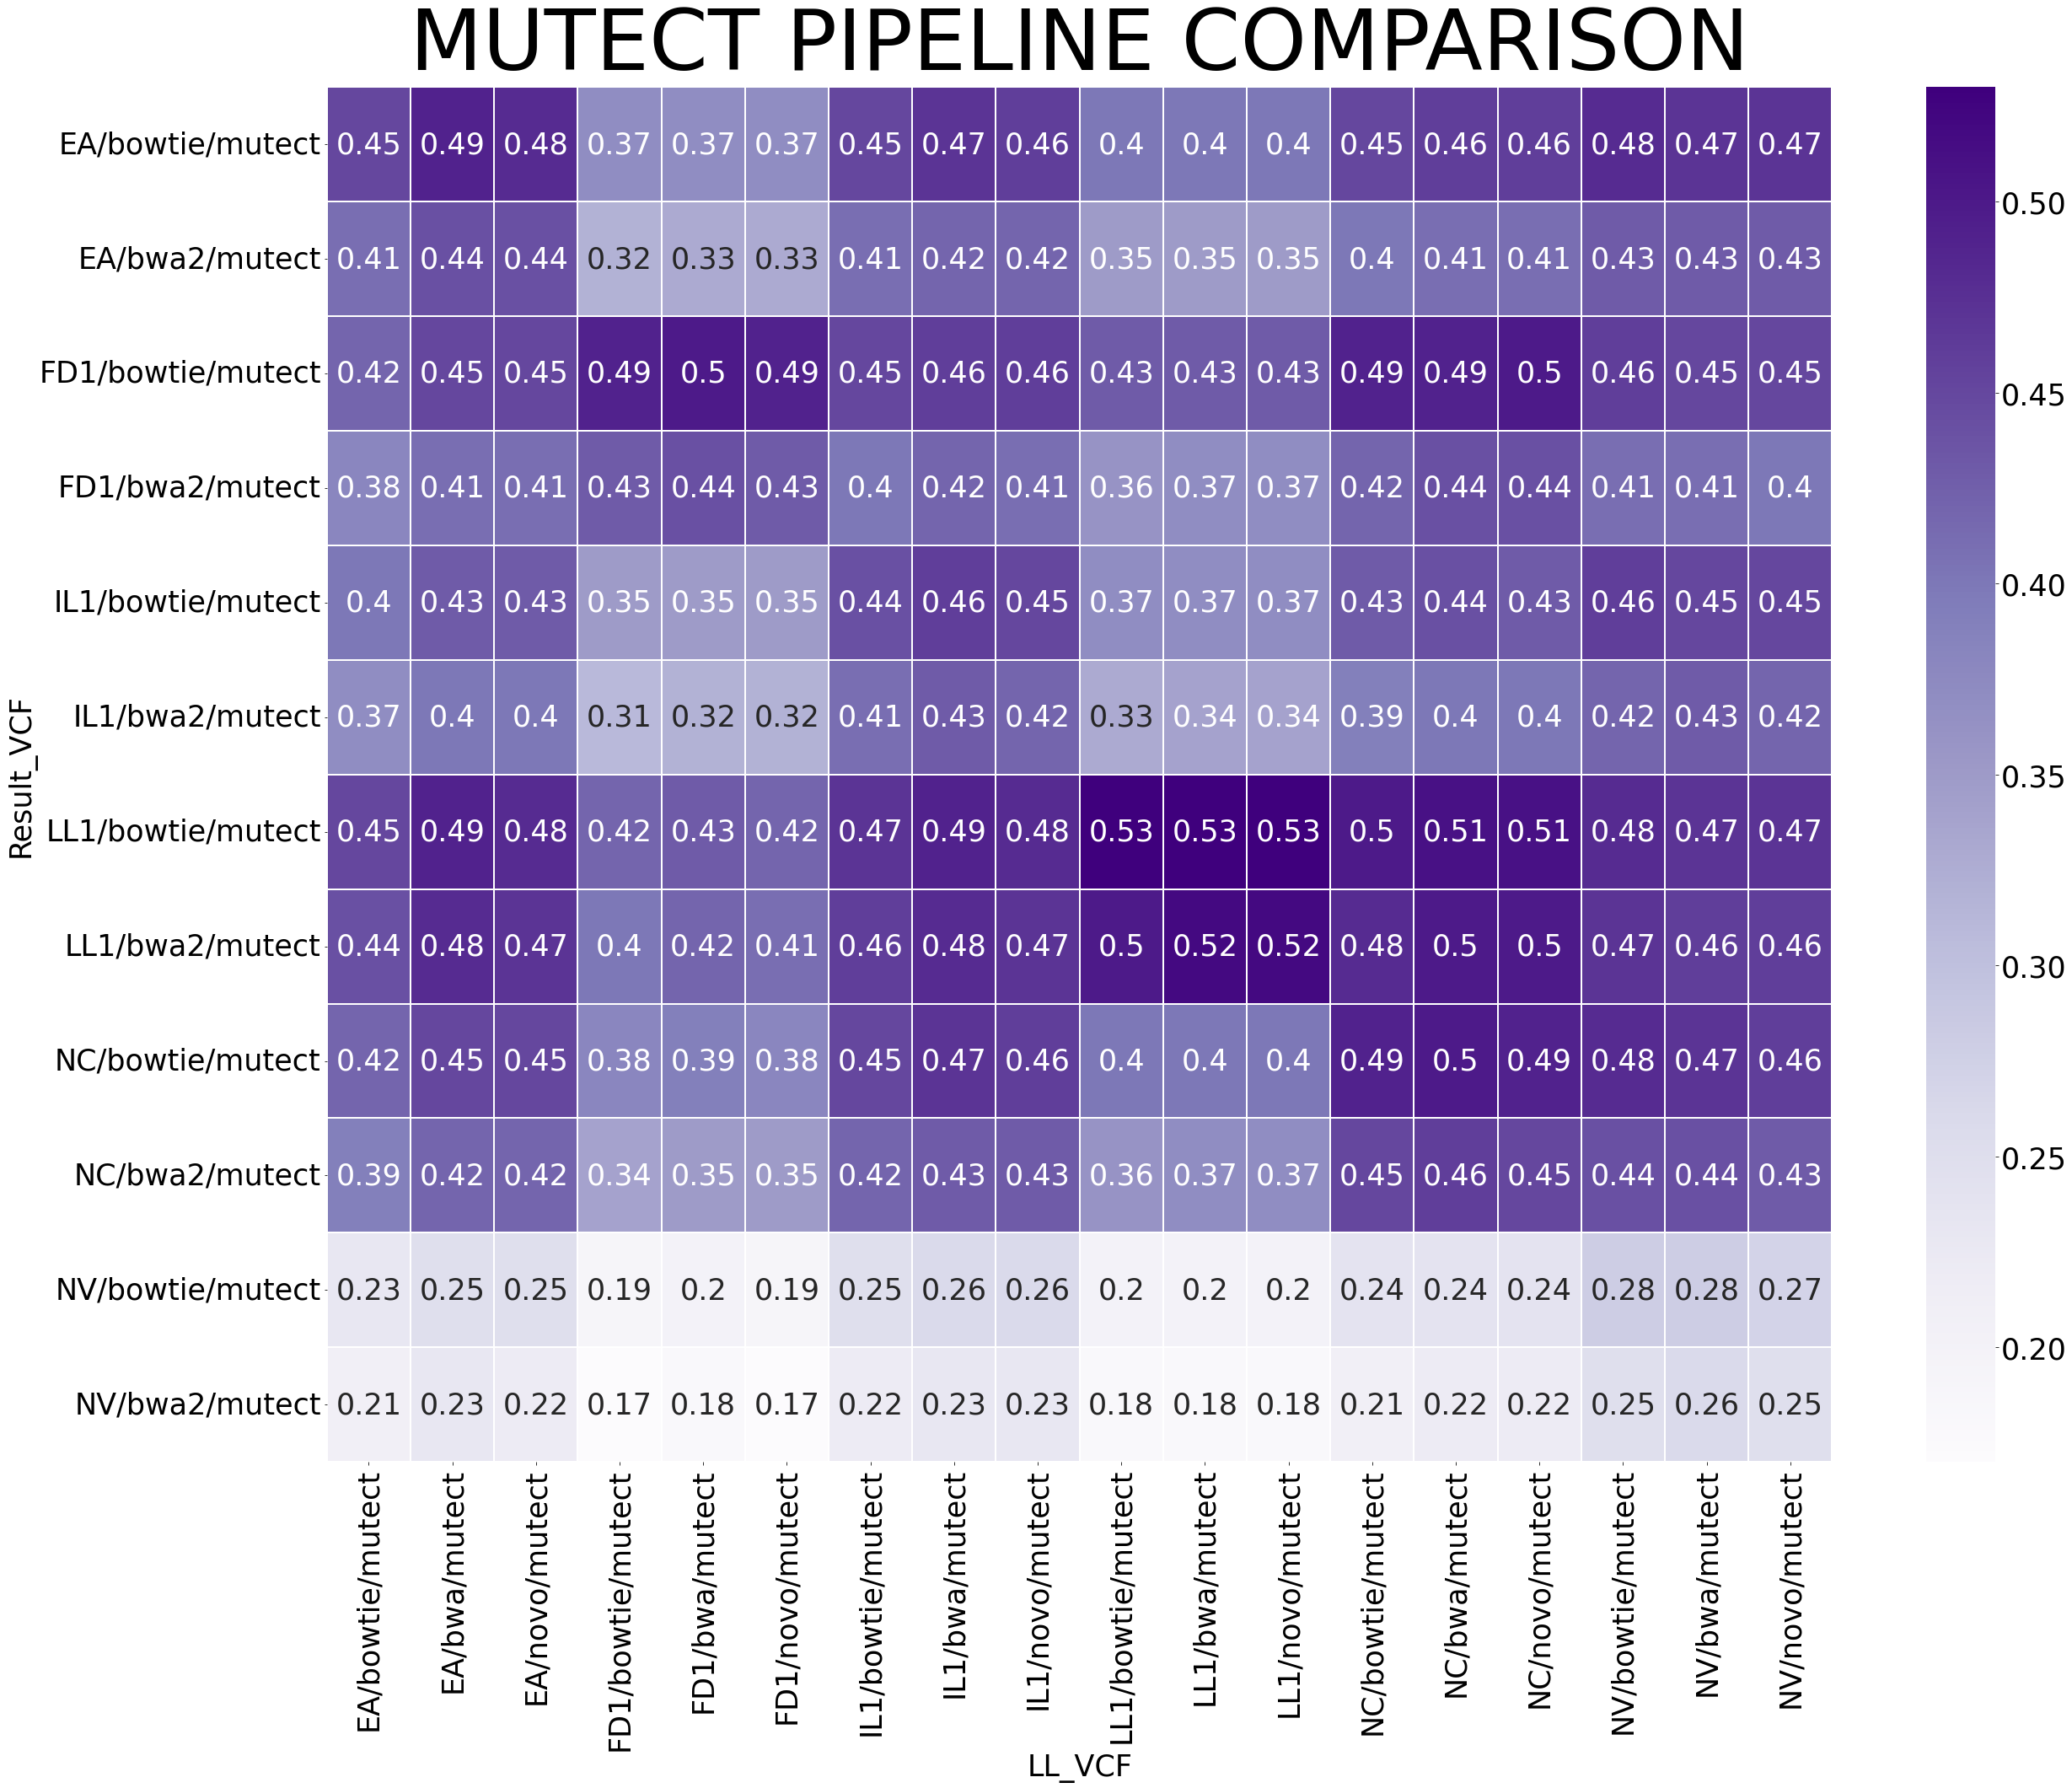

In [261]:
### mutect
plt.figure(figsize = (40,30))
plt.title('MUTECT PIPELINE COMPARISON', size = 100)
t_mutect_h = df_mutect.pivot("Result_VCF", "LL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(t_mutect_h, annot=True, cmap="Purples", linewidths=.2)

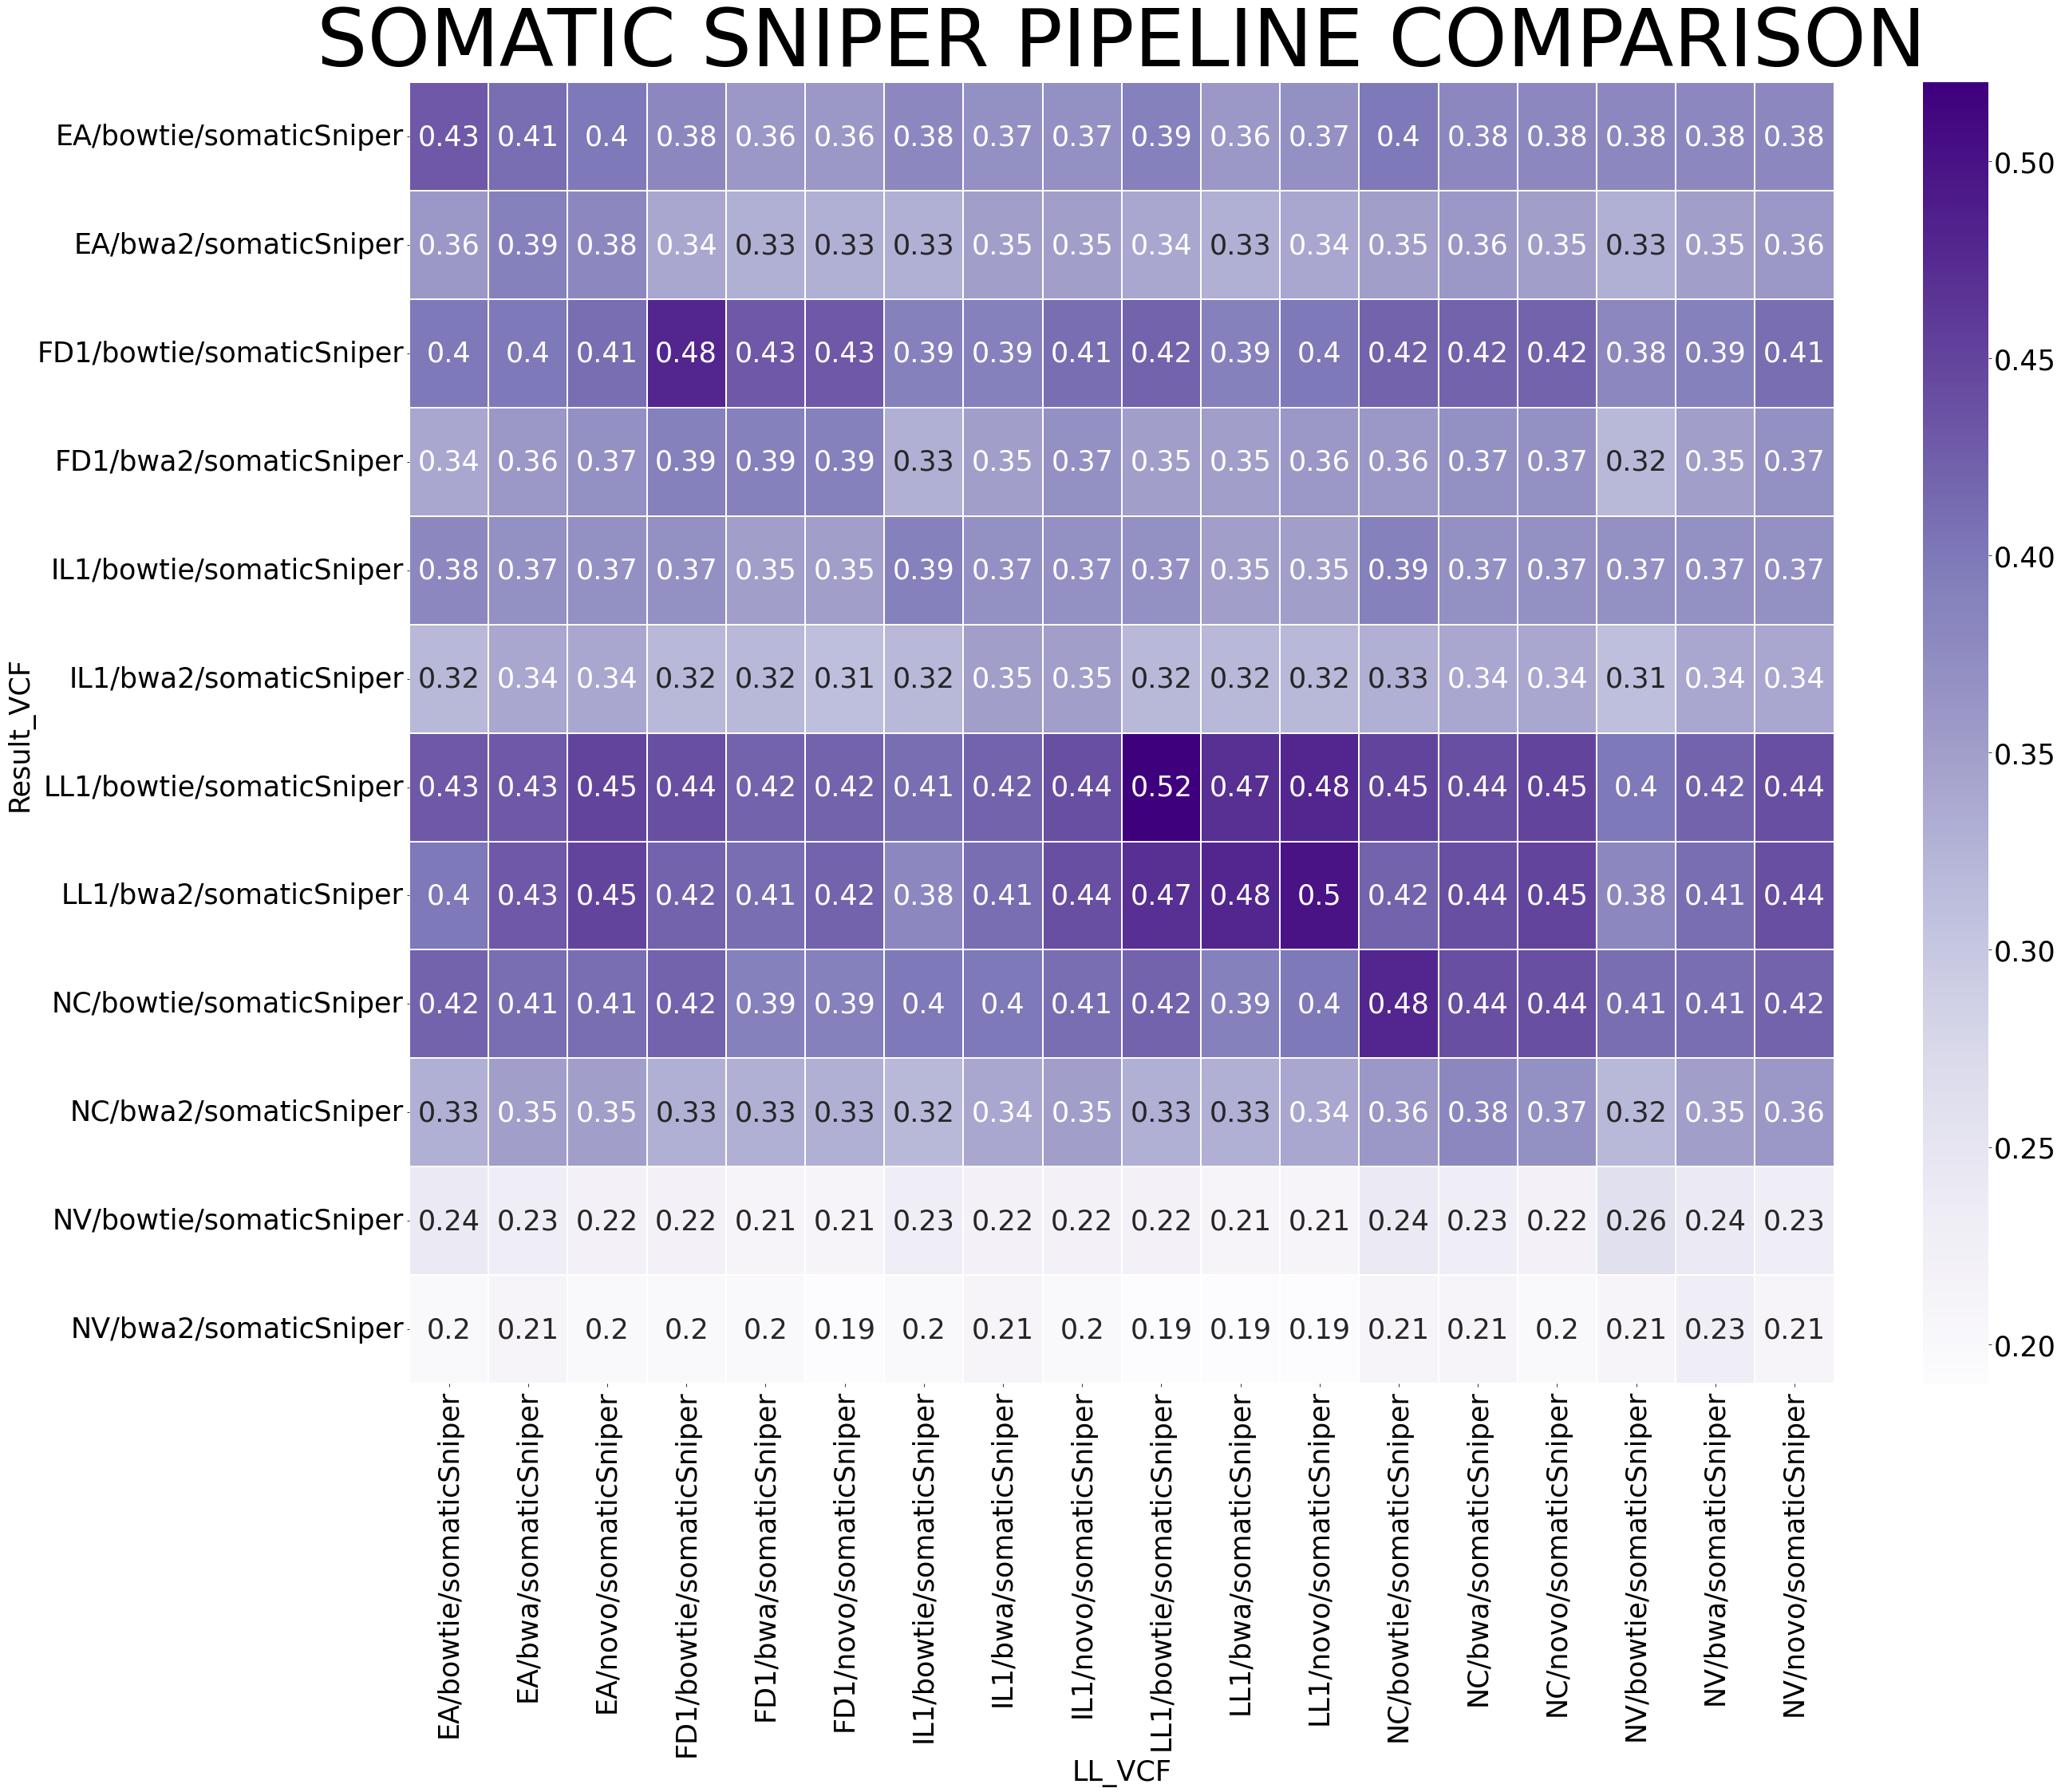

In [262]:
### somaticSniper
plt.figure(figsize = (40,30))
plt.title('SOMATIC SNIPER PIPELINE COMPARISON', size = 100)
t_ss_h = df_ss.pivot("Result_VCF", "LL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(t_ss_h, annot=True, cmap="Purples", linewidths=.2)

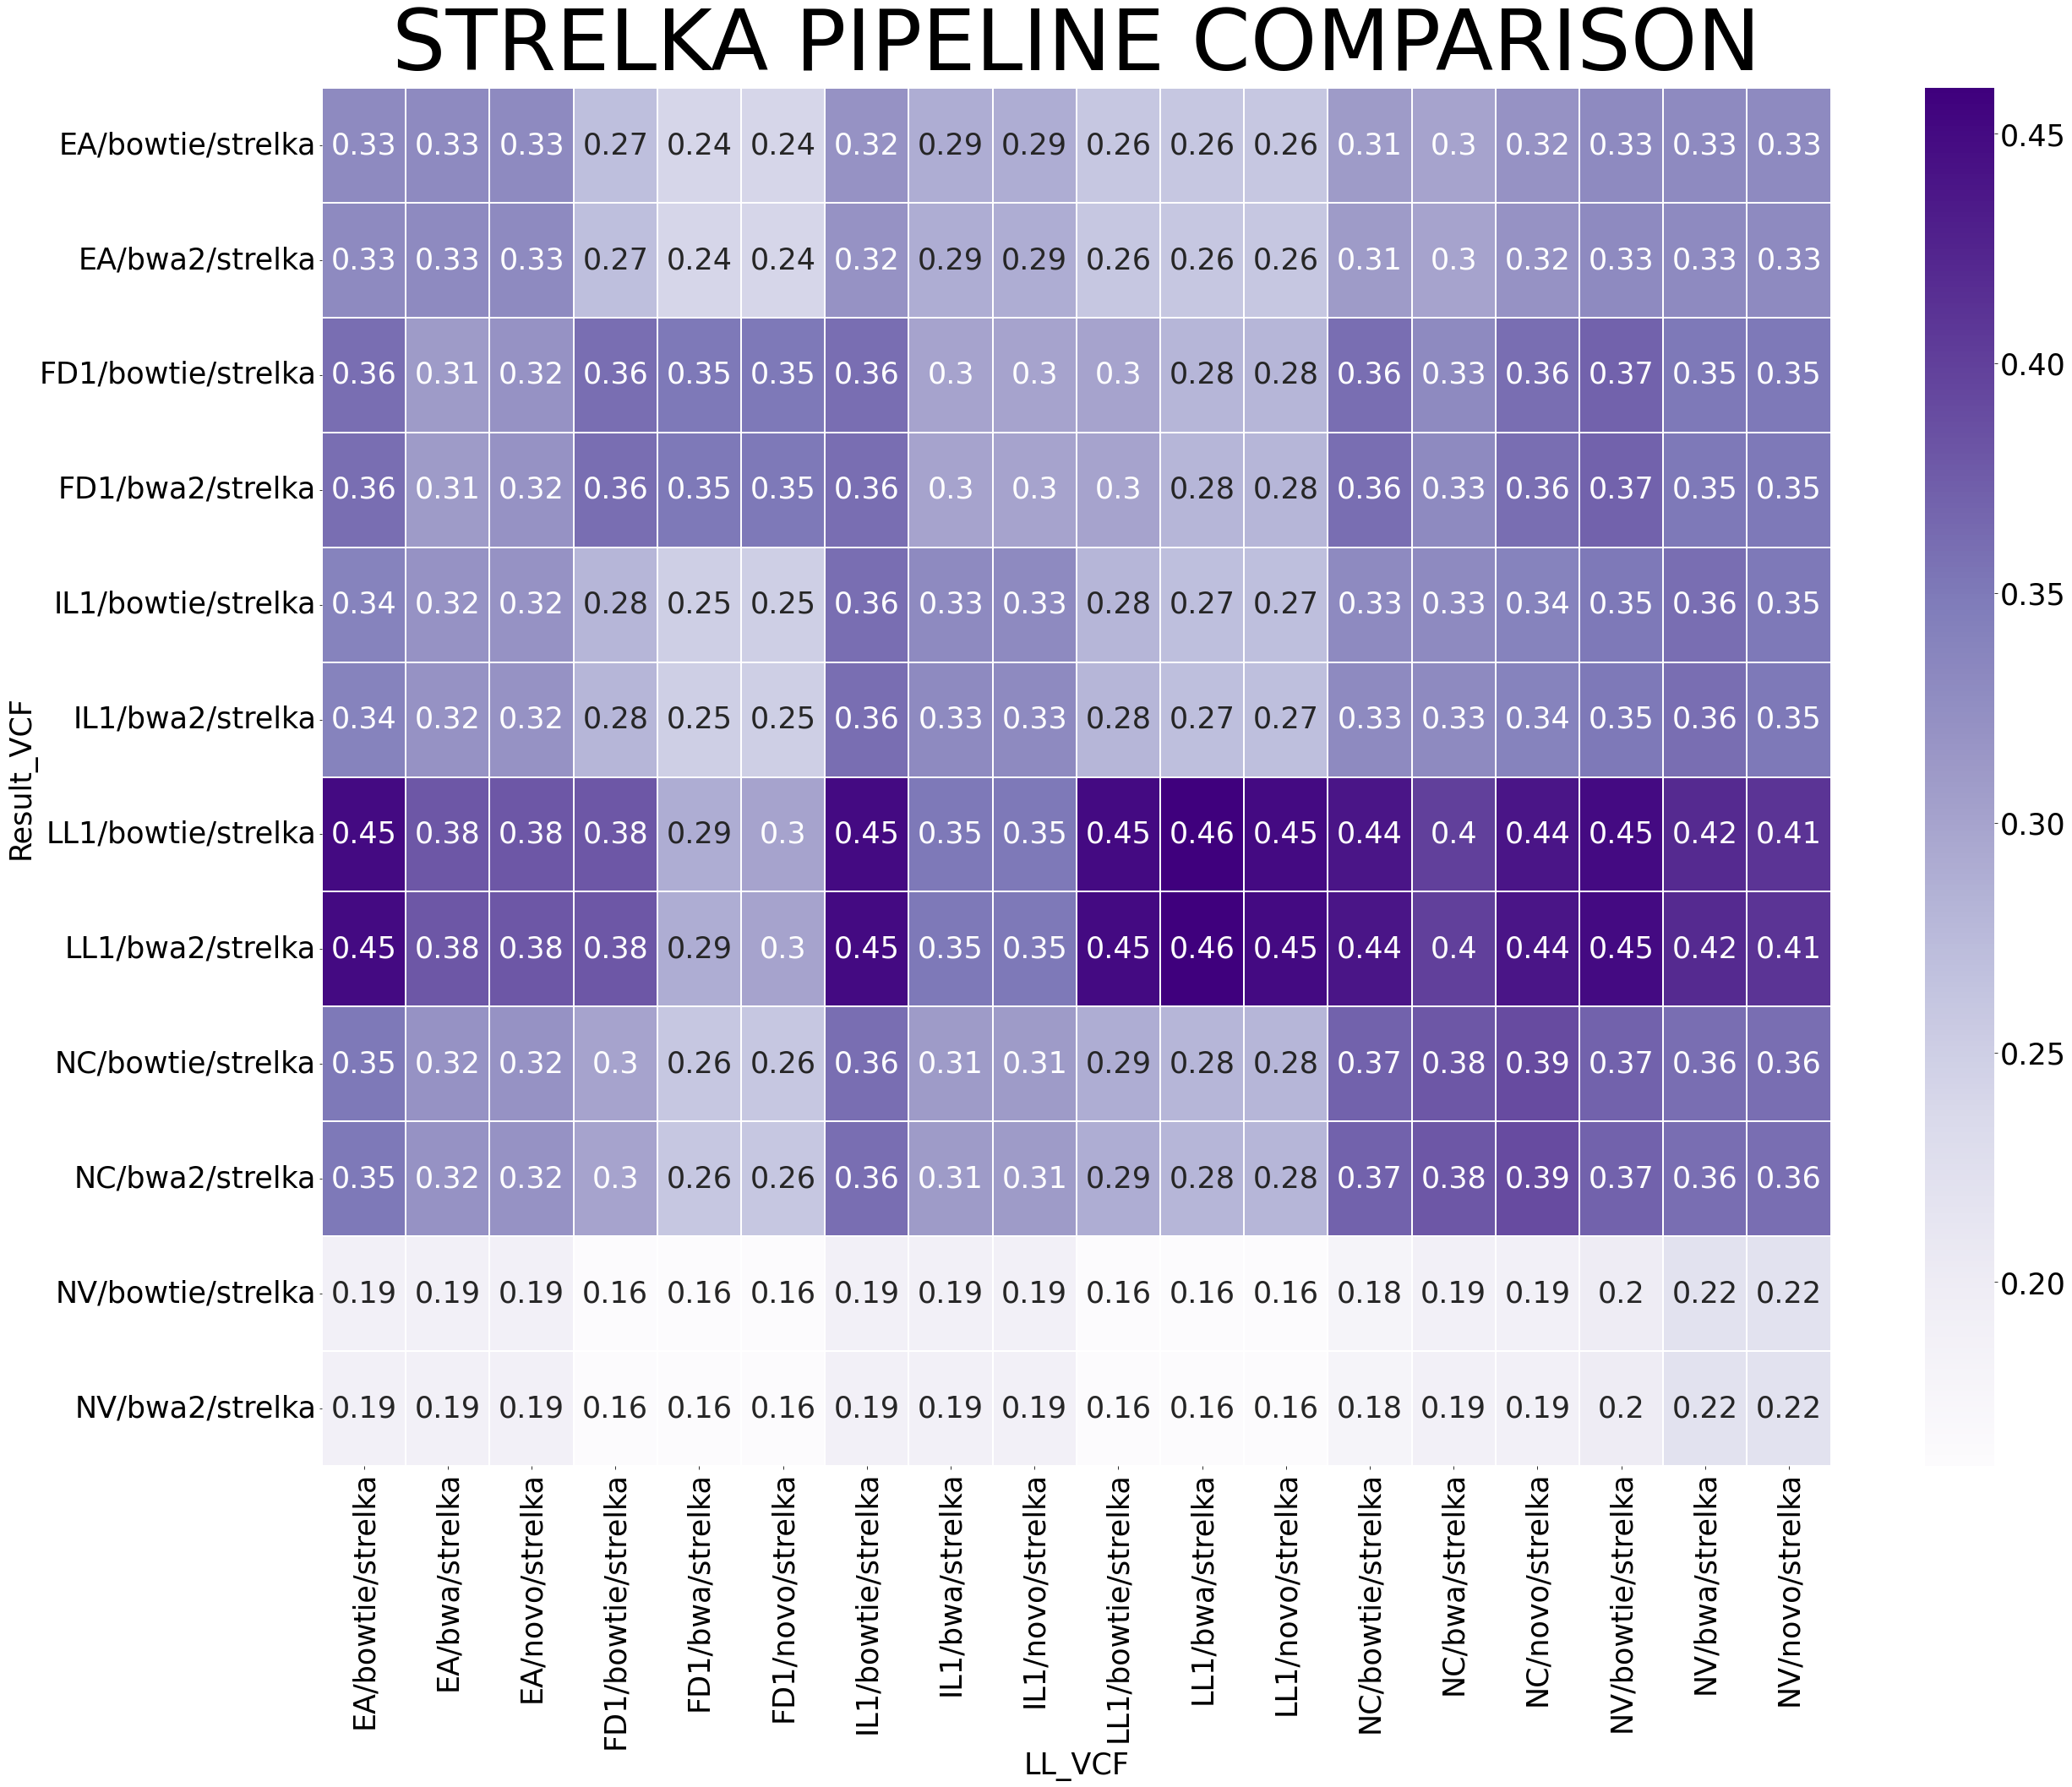

In [263]:
### strelka
plt.figure(figsize = (40,30))
plt.title('STRELKA PIPELINE COMPARISON', size = 100)
t_strelka_h = df_strelka.pivot("Result_VCF", "LL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(t_strelka_h, annot=True, cmap="Purples", linewidths=.2)

## PART D) COMPARISON WITH UNION VALIDATED VCF'S

### 1- Create an union of all ll validated vfc sets for each data

In [15]:
union_v_vcf = {}
for key, value in ll_sets_dict.items():
    union_v_vcf[key[:len(key.split('/')[0])]] = union_v_vcf.get(key[:len(key.split('/')[0])], set()) | value

In [16]:
#Initializing a dataframe
df_union = pd.DataFrame(columns=["V_VCF", "Result_VCF", "Results", 'length'])

#Initializing a count for the rows
count = 0

#Computing each intersection of ll and the pipeline vcfs by looking at their key values. 
for key1 in sets_dict:
    df_union[count] = [((key1.split('/')[0]).split('(')[0]).upper(), key1, js_set(union_v_vcf[((key1.split('/')[0]).split('(')[0]).upper()],sets_dict[key1]),len(union_v_vcf[((key1.split('/')[0]).split('(')[0]).upper()]) ]
    count += 1

#Taking transpose of the df and, getting rid of the first three rows then renaming axis again.
df_union = df_union.transpose().iloc[4: , :].set_axis(['V_VCF', 'Result_VCF', 'Results', 'length'], axis=1, inplace=False)

#df_union

### 2- Show results in heatmap

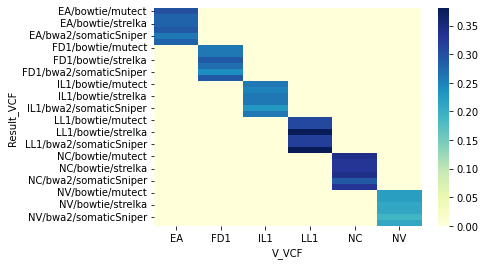

In [17]:
df_union_h = df_union.pivot("Result_VCF", "V_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_union_h, annot=False,cmap="YlGnBu")

## PART E) OPENCRAVAT DATA

### 1 - read results from https://run.opencravat.org/submit/nocache/index.html for pipeline

In [30]:
oc_filenames = {}
for root, directories, filenames in os.walk('vcf/openCravat/pipeline'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            oc_filenames[fn.split('.')[0]] = os.path.join(root,fn)

In [31]:
oc_dict = {}
oc_geneDict = {}

for key in tqdm(oc_filenames):
    
    temp = pd.read_csv(oc_filenames[key], delimiter= '\t', skiprows = 6)
    oc_dict[key]= list(temp['Sequence_Ontology'])
    oc_geneDict[key]= list(temp['Gene'])

 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.02it/s]/Users/P33833/miniconda3/envs/mywork1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.16it/s]


### 2 - Show Sequence_Ontology for each pipeline data

In [32]:
oc_results = pd.DataFrame(columns=["KEY", "Sequence_Ontology", "Count"])
for key in oc_dict:
    values, counts = np.unique(oc_dict[key], return_counts=True)
    for x in range(len(values)):
        oc_results.loc[len(oc_results.index)] = [key,values[x],counts[x]]

In [33]:
pd.set_option('display.max_rows', oc_results.shape[0]+1)
oc_results = oc_results.sort_values(by=['Count'])

#print(oc_results)

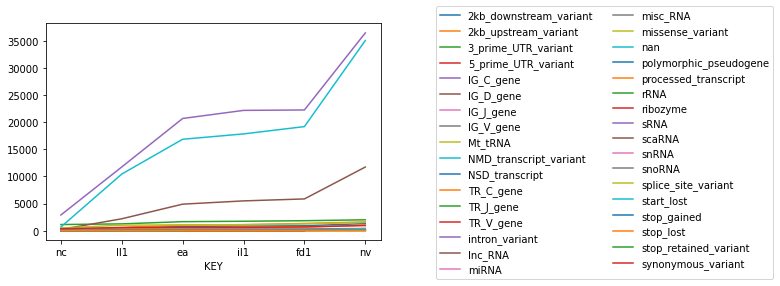

In [68]:
oc_df = oc_results.copy()
oc_df.set_index('KEY', inplace=True)
oc_df = oc_df.sort_values(by=['Count'])
oc_df.groupby('Sequence_Ontology')['Count'].plot()
#plt.legend(loc=(-1, -1))
plt.legend(bbox_to_anchor =(1.15, 1.10), ncol = 2)

In [283]:
oc_df = oc_results.copy()
import plotly.express as px
fig = px.histogram(oc_df, x="KEY", y="Count",
             color='Sequence_Ontology', barmode='group',
             height=400, title='Sequence_Ontology Results on Pipeline Results')
fig.update_xaxes(categoryorder='category ascending')
fig.show()

### 3 - read results from https://run.opencravat.org/submit/nocache/index.html for validated vcfs

In [35]:
oc_v_filenames = {}
for root, directories, filenames in os.walk('vcf/openCravat/validated'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            oc_v_filenames[fn.split('.')[0]] = os.path.join(root,fn)

In [36]:
oc_v_dict = {}
oc_v_geneDict = {}

for key in tqdm(oc_v_filenames):
    
    temp = pd.read_csv(oc_v_filenames[key], delimiter= '\t', skiprows = 6)
    oc_v_dict[key] = list(temp['Sequence_Ontology'])
    oc_v_geneDict[key] = list(temp['Gene'])

 33%|███████████████                              | 2/6 [00:00<00:00,  9.66it/s]/Users/P33833/miniconda3/envs/mywork1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.64it/s]


### 4 - Show Sequence_Ontology for each validated data

In [37]:
oc_v_results = pd.DataFrame(columns=["KEY", "Sequence_Ontology", "Count"])
for key in oc_v_dict:
    values, counts = np.unique(oc_v_dict[key], return_counts=True)
    for x in range(len(values)):
        oc_v_results.loc[len(oc_v_results.index)] = [key,values[x],counts[x]]

In [106]:
oc_results.tail()

KEY Sequence_Ontology  Count
36   fd1    intron_variant  20685
65   il1    intron_variant  22178
93    ea    intron_variant  22255
159   nc               nan  35059
154   nc    intron_variant  36468

In [38]:
pd.set_option('display.max_rows', oc_v_results.shape[0]+1)
oc_v_results = oc_v_results.sort_values(by=['Count'])

#print(oc_v_results)

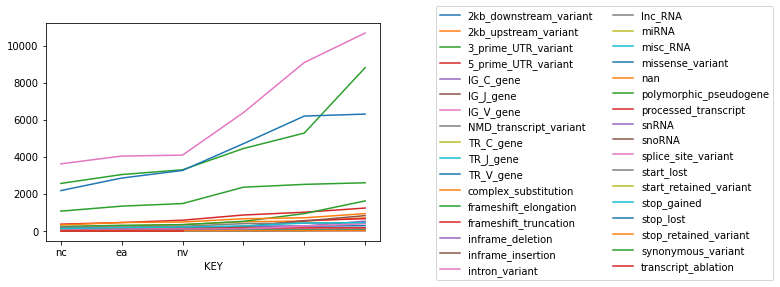

In [39]:
oc_v_df = oc_v_results.copy()
oc_v_df.set_index('KEY', inplace=True)
oc_v_df = oc_v_df.sort_values(by=['Count'])
oc_v_df.groupby('Sequence_Ontology')['Count'].plot()
plt.legend(bbox_to_anchor =(1.15, 1.10), ncol = 2)

In [281]:
oc_v_df = oc_v_results.copy()
import plotly.express as px
fig = px.histogram(oc_v_df, x="KEY", y="Count",
             color='Sequence_Ontology', barmode='group',
             height=400, title='Sequence_Ontology Results on Validated Results')
fig.update_xaxes(categoryorder='category ascending')
fig.show()

### GENE FOR PIPELINE

In [40]:
oc_geneResults = pd.DataFrame(columns=["KEY", "Gene", "Count"])
for key in tqdm(oc_geneDict):
    values, counts = np.unique(oc_geneDict[key], return_counts=True)
    for x in range(len(values)):
        oc_geneResults.loc[len(oc_geneResults.index)] = [key,values[x],counts[x]]

100%|█████████████████████████████████████████████| 6/6 [05:01<00:00, 50.22s/it]


In [109]:
pd.set_option('display.max_rows', oc_geneResults.shape[0]+1)
df_p = oc_geneResults.copy().reset_index(drop=True) 

### GENE FOR VALIDATED

In [93]:
oc_v_geneResults = pd.DataFrame(columns=["KEY", "Gene", "Count"])
for key in tqdm(oc_v_geneDict):
    values, counts = np.unique(oc_v_geneDict[key], return_counts=True)
    for x in range(len(values)):
        oc_v_geneResults.loc[len(oc_v_geneResults.index)] = [key,values[x],counts[x]]

100%|█████████████████████████████████████████████| 6/6 [02:33<00:00, 25.57s/it]


In [110]:
pd.set_option('display.max_rows', oc_v_geneResults.shape[0]+1)
df_v = oc_v_geneResults.copy()

### GENE COMPARISON

In [112]:
df_p["type"] = "pipeline"
df_v["type"] = "validation"

df = pd.concat([df_p, df_v]).reset_index(drop=True)

df = df.dropna(subset=["Gene"]).reset_index(drop=True)

df = df.rename(columns={
    "KEY": "dataset",
    "Gene": "gene",
    "Count": "count"
})

df = df[df["count"] > 5].reset_index(drop=True)


In [284]:
for dataset, frame in df.groupby("dataset"):
    genes = frame["gene"][frame["gene"].duplicated()]
    frame = frame[frame["gene"].isin(set(genes))]
    fig = px.bar(frame, x="gene", y="count", color="type", title=dataset) 
    fig.update_layout(barmode='group', xaxis={'categoryorder':'total descending'})
    fig.show()

In [114]:
for dataset, frame in df.groupby("dataset"):
    break

In [115]:
f1 = df[df["type"] == "pipeline"].set_index(["dataset", "gene"])
f1.columns += "_1"

In [116]:
f2 = df[df["type"] == "validation"].set_index(["dataset", "gene"])
f2.columns += "_2"

In [117]:
f = pd.concat([f1, f2], axis=1)

In [118]:
f["delta"] = f["count_1"] - f["count_2"]

In [142]:
f = f.dropna(subset=["delta"])
f = f.dropna(subset=["gene"])

In [147]:
f["abs_delta"] = f["delta"].apply(abs)
f

count_1    type_1 count_2      type_2  delta  \
dataset gene                                                                  
ea      ABCA13                      10  pipeline       8  validation      2   
        ABCA4                        7  pipeline      11  validation     -4   
        ABCC11                      24  pipeline      13  validation     11   
        AC005747.1                   9  pipeline       6  validation      3   
        AC009022.1                  16  pipeline       6  validation     10   
        AC139099.2                   7  pipeline      20  validation    -13   
        ADAD2                        9  pipeline       9  validation      0   
        ADAMTS17                    12  pipeline       6  validation      6   
        ADCY1                       15  pipeline       6  validation      9   
        ADGRB1                      13  pipeline      13  validation      0   
        ADGRE2                      10  pipeline       6  validation      4   
        ADGRG1                      14  pipeline       9  validation      5   
        ADGRG5                       9  pipeline       9  validation      0   
        AF241726.2                  14  pipeline      12  validation      2   
        AGAP1                        8  pipeline      12  validation     -4   
        AHNAK                        8  pipeline       6  validation      2   
        AHRR                        13  pipeline       9  validation      4   
        AL133268.4                   6  pipeline       7  validation     -1   
        ALDH5A1                      9  pipeline       8  validation      1   
        ALG6                         7  pipeline       6  validation      1   
        ALK                         14  pipeline       8  validation      6   
        ALMS1                        6  pipeline      11  validation     -5   
        ALPP                         7  pipeline      13  validation     -6   
        ANK3                        10  pipeline       6  validation      4   
        ANKRD36C                    11  pipeline       7  validation      4   
        ANKS1A                      10  pipeline       9  validation      1   
        ANO1                         6  pipeline      13  validation     -7   
        ARHGAP42                    11  pipeline       7  validation      4   
        ARHGEF3                      7  pipeline       7  validation      0   
        ASH1L                        6  pipeline       7  validation     -1   
        ASMTL                       24  pipeline       8  validation     16   
        ATG5                         6  pipeline       6  validation      0   
        ATP11A                       7  pipeline       8  validation     -1   
        ATP2C2                      15  pipeline      14  validation      1   
        ATR                          8  pipeline      10  validation     -2   
        ATXN1                       14  pipeline      11  validation      3   
        AXDND1                      15  pipeline       6  validation      9   
        BAHCC1                      14  pipeline      20  validation     -6   
        BBS2                        13  pipeline       9  validation      4   
        BCO1                        16  pipeline       8  validation      8   
        BLOC1S5                      6  pipeline       6  validation      0   
        BTN1A1                       8  pipeline      11  validation     -3   
        C4orf50                     11  pipeline       6  validation      5   
        C6orf132                    21  pipeline      11  validation     10   
        CACNA1A                     29  pipeline      12  validation     17   
        CACNA1D                      7  pipeline       8  validation     -1   
        CACNA1I                     11  pipeline      10  validation      1   
        CADPS                        7  pipeline       7  validation      0   
        CASZ1                        7  pipeline       9  validation     -2   
  

In [145]:
f  = f.set_index(["dataset", "gene"])

In [150]:
fig = px.bar(f[f["abs_delta"] > 10].reset_index().sort_values("abs_delta", ascending=False).head(50), x="gene", y="delta", color="dataset", title="pipeline - validation")
fig.update_layout(barmode='group', xaxis={'categoryorder':'total descending'})
fig.show()